In [31]:
import os
import time
import torch
import functools
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from functorch import make_functional
from tqdm.auto import tqdm

In [27]:
def utils_cross_entropy(params, func, x, t):
    # Compute the prediction
    y_pred = func(params, x)
    # Compute the CE loss
    loss = F.cross_entropy(y_pred, t, reduction='mean')
    return loss

In [4]:
# Paper FNN
class FNN(nn.Module):
    def __init__(self):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(784, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Paper CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(in_features=3136, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 3136)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [12]:
data_dir = 'D:/data/'
# Download dataset: set to true if you don't have it saved locally
download_dataset = True if os.path.exists(data_dir + 'mnist') else False

# Load the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Define the batch size
batch_size = 64

# Create train and test dataset...
train_dataset = torchvision.datasets.MNIST(root=data_dir, train=True, download=download_dataset, transform=transform)
test_dataset = torchvision.datasets.MNIST(root=data_dir, train=False, download=download_dataset, transform=transform)

# ... and respective dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [36]:
func, params = make_functional(FNN())
params

C:\Users\MOSS_8192\AppData\Local\Temp\ipykernel_8840\1367907692.py:1: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  func, params = make_functional(FNN())


(Parameter containing:
 tensor([[ 0.0063,  0.0211,  0.0177,  ...,  0.0300,  0.0322, -0.0225],
         [-0.0318, -0.0170, -0.0280,  ..., -0.0077, -0.0014,  0.0031],
         [-0.0129, -0.0079,  0.0276,  ...,  0.0343, -0.0269,  0.0191],
         ...,
         [-0.0303, -0.0029, -0.0324,  ..., -0.0117,  0.0105, -0.0319],
         [ 0.0074, -0.0179, -0.0061,  ...,  0.0020, -0.0197, -0.0263],
         [-0.0341,  0.0119,  0.0113,  ...,  0.0170,  0.0344,  0.0223]],
        requires_grad=True),
 Parameter containing:
 tensor([-2.2597e-02, -2.2120e-02, -1.4868e-02,  ...,  1.2657e-02,
         -2.3954e-05,  1.1002e-02], requires_grad=True),
 Parameter containing:
 tensor([[-0.0302,  0.0304,  0.0157,  ...,  0.0239,  0.0187,  0.0240],
         [ 0.0250,  0.0156, -0.0240,  ...,  0.0003,  0.0221, -0.0006],
         [ 0.0082, -0.0303, -0.0184,  ...,  0.0309,  0.0149, -0.0253],
         ...,
         [-0.0230, -0.0001,  0.0107,  ...,  0.0201, -0.0006,  0.0039],
         [ 0.0287, -0.0044,  0.0042,  .

In [37]:
# Given a model, train it using FGD
def train_fgd(model, train_loader, num_epochs=20, learning_rate=2e-4, input_size=28*28):
    print(f'\n\nTraining {model.__class__.__name__} with FGD for {num_epochs} epochs...')

    # Initialize losses and times
    losses = list()
    times = list([0])

    with torch.no_grad():
        # Get the functional version of the model with functorch
        func, params = make_functional(model)
        
        # Train the network with FGD (forward Gradient Descent)
        for epoch in tqdm(range(num_epochs)): 
            for i, (images, labels) in enumerate(train_loader): 
                # Start time
                t0 = time.time()
                # Reshape the images (for FNN only)
                if isinstance(model, FNN): images = images.reshape(-1, input_size)
                # Create callable CE function
                f = functools.partial(utils_cross_entropy, func=func, x=images, t=labels)            
                # Sample perturbation (for each parameter of the model)
                v_params = tuple([torch.randn_like(p) for p in params])  
                # Forward AD
                loss, jvp = torch.func.jvp(f, (tuple(params),), (v_params,))
                # Decay learning rate
                l_rate = learning_rate * np.exp(-((i+epoch*len(train_loader))*1e-4))
                # For each parameter
                for j, p in enumerate(params):
                    # Compute forward gradient
                    g = jvp * v_params[j]
                    # Parameters update
                    p.sub_(l_rate * g)  
                # End time
                t1 = time.time()     
                # Update losses and times
                losses.append(loss)
                times.append(times[-1]+t1-t0)     
                # Print the statistics
                if (i+1) % batch_size == 0:
                    print (f'Epoch [{epoch+1}/{num_epochs}],\tStep [{i+1}/{len(train_loader)}],\t' +
                            f'Iteraion [{i+1+epoch*len(train_loader)}/{len(train_loader)*num_epochs}],\t' +
                            f'Loss: {loss:.4f},\tTime: {t1-t0:.2f}')
    print('Finished FGD Training')
    return losses, times

C:\Users\MOSS_8192\AppData\Local\Temp\ipykernel_8840\2394295025.py:11: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  func, params = make_functional(model)




Training FNN with FGD for 20 epochs...


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20],	Step [64/938],	Iteraion [64/18760],	Loss: 2.3052,	Time: 0.02
Epoch [1/20],	Step [128/938],	Iteraion [128/18760],	Loss: 2.3054,	Time: 0.01
Epoch [1/20],	Step [192/938],	Iteraion [192/18760],	Loss: 2.2861,	Time: 0.02
Epoch [1/20],	Step [256/938],	Iteraion [256/18760],	Loss: 2.2755,	Time: 0.02
Epoch [1/20],	Step [320/938],	Iteraion [320/18760],	Loss: 2.2830,	Time: 0.02
Epoch [1/20],	Step [384/938],	Iteraion [384/18760],	Loss: 2.2853,	Time: 0.02
Epoch [1/20],	Step [448/938],	Iteraion [448/18760],	Loss: 2.2746,	Time: 0.02
Epoch [1/20],	Step [512/938],	Iteraion [512/18760],	Loss: 2.2468,	Time: 0.00
Epoch [1/20],	Step [576/938],	Iteraion [576/18760],	Loss: 2.2528,	Time: 0.02
Epoch [1/20],	Step [640/938],	Iteraion [640/18760],	Loss: 2.2578,	Time: 0.02
Epoch [1/20],	Step [704/938],	Iteraion [704/18760],	Loss: 2.2366,	Time: 0.02
Epoch [1/20],	Step [768/938],	Iteraion [768/18760],	Loss: 2.2487,	Time: 0.01
Epoch [1/20],	Step [832/938],	Iteraion [832/18760],	Loss: 2.2177,	Time: 0.02
E

  5%|▌         | 1/20 [00:24<07:44, 24.45s/it]

Epoch [2/20],	Step [64/938],	Iteraion [1002/18760],	Loss: 2.2149,	Time: 0.02
Epoch [2/20],	Step [128/938],	Iteraion [1066/18760],	Loss: 2.1927,	Time: 0.01
Epoch [2/20],	Step [192/938],	Iteraion [1130/18760],	Loss: 2.2275,	Time: 0.02
Epoch [2/20],	Step [256/938],	Iteraion [1194/18760],	Loss: 2.1962,	Time: 0.02
Epoch [2/20],	Step [320/938],	Iteraion [1258/18760],	Loss: 2.2068,	Time: 0.01
Epoch [2/20],	Step [384/938],	Iteraion [1322/18760],	Loss: 2.2019,	Time: 0.00
Epoch [2/20],	Step [448/938],	Iteraion [1386/18760],	Loss: 2.2094,	Time: 0.02
Epoch [2/20],	Step [512/938],	Iteraion [1450/18760],	Loss: 2.1799,	Time: 0.02
Epoch [2/20],	Step [576/938],	Iteraion [1514/18760],	Loss: 2.1618,	Time: 0.01
Epoch [2/20],	Step [640/938],	Iteraion [1578/18760],	Loss: 2.1623,	Time: 0.02
Epoch [2/20],	Step [704/938],	Iteraion [1642/18760],	Loss: 2.1554,	Time: 0.02
Epoch [2/20],	Step [768/938],	Iteraion [1706/18760],	Loss: 2.1745,	Time: 0.02
Epoch [2/20],	Step [832/938],	Iteraion [1770/18760],	Loss: 2.1283

 10%|█         | 2/20 [00:48<07:17, 24.29s/it]

Epoch [3/20],	Step [64/938],	Iteraion [1940/18760],	Loss: 2.1710,	Time: 0.02
Epoch [3/20],	Step [128/938],	Iteraion [2004/18760],	Loss: 2.1392,	Time: 0.02
Epoch [3/20],	Step [192/938],	Iteraion [2068/18760],	Loss: 2.0826,	Time: 0.02
Epoch [3/20],	Step [256/938],	Iteraion [2132/18760],	Loss: 2.1064,	Time: 0.02
Epoch [3/20],	Step [320/938],	Iteraion [2196/18760],	Loss: 2.1300,	Time: 0.02
Epoch [3/20],	Step [384/938],	Iteraion [2260/18760],	Loss: 2.1340,	Time: 0.01
Epoch [3/20],	Step [448/938],	Iteraion [2324/18760],	Loss: 2.0841,	Time: 0.00
Epoch [3/20],	Step [512/938],	Iteraion [2388/18760],	Loss: 2.0651,	Time: 0.00
Epoch [3/20],	Step [576/938],	Iteraion [2452/18760],	Loss: 2.1085,	Time: 0.02
Epoch [3/20],	Step [640/938],	Iteraion [2516/18760],	Loss: 2.0990,	Time: 0.02
Epoch [3/20],	Step [704/938],	Iteraion [2580/18760],	Loss: 2.0935,	Time: 0.02
Epoch [3/20],	Step [768/938],	Iteraion [2644/18760],	Loss: 2.0664,	Time: 0.02
Epoch [3/20],	Step [832/938],	Iteraion [2708/18760],	Loss: 2.0672

 15%|█▌        | 3/20 [01:13<06:53, 24.34s/it]

Epoch [4/20],	Step [64/938],	Iteraion [2878/18760],	Loss: 2.0088,	Time: 0.00
Epoch [4/20],	Step [128/938],	Iteraion [2942/18760],	Loss: 1.9998,	Time: 0.02
Epoch [4/20],	Step [192/938],	Iteraion [3006/18760],	Loss: 2.0300,	Time: 0.02
Epoch [4/20],	Step [256/938],	Iteraion [3070/18760],	Loss: 2.0033,	Time: 0.02
Epoch [4/20],	Step [320/938],	Iteraion [3134/18760],	Loss: 1.9110,	Time: 0.02
Epoch [4/20],	Step [384/938],	Iteraion [3198/18760],	Loss: 1.9938,	Time: 0.02
Epoch [4/20],	Step [448/938],	Iteraion [3262/18760],	Loss: 1.9638,	Time: 0.01
Epoch [4/20],	Step [512/938],	Iteraion [3326/18760],	Loss: 2.0190,	Time: 0.01
Epoch [4/20],	Step [576/938],	Iteraion [3390/18760],	Loss: 1.9811,	Time: 0.02
Epoch [4/20],	Step [640/938],	Iteraion [3454/18760],	Loss: 1.9876,	Time: 0.01
Epoch [4/20],	Step [704/938],	Iteraion [3518/18760],	Loss: 1.9299,	Time: 0.02
Epoch [4/20],	Step [768/938],	Iteraion [3582/18760],	Loss: 1.9226,	Time: 0.02
Epoch [4/20],	Step [832/938],	Iteraion [3646/18760],	Loss: 1.8809

 20%|██        | 4/20 [01:37<06:28, 24.29s/it]

Epoch [5/20],	Step [64/938],	Iteraion [3816/18760],	Loss: 1.8088,	Time: 0.02
Epoch [5/20],	Step [128/938],	Iteraion [3880/18760],	Loss: 1.8397,	Time: 0.02
Epoch [5/20],	Step [192/938],	Iteraion [3944/18760],	Loss: 1.8818,	Time: 0.02
Epoch [5/20],	Step [256/938],	Iteraion [4008/18760],	Loss: 1.8523,	Time: 0.02
Epoch [5/20],	Step [320/938],	Iteraion [4072/18760],	Loss: 1.7776,	Time: 0.02
Epoch [5/20],	Step [384/938],	Iteraion [4136/18760],	Loss: 1.7722,	Time: 0.02
Epoch [5/20],	Step [448/938],	Iteraion [4200/18760],	Loss: 1.7909,	Time: 0.02
Epoch [5/20],	Step [512/938],	Iteraion [4264/18760],	Loss: 1.8255,	Time: 0.03
Epoch [5/20],	Step [576/938],	Iteraion [4328/18760],	Loss: 1.8080,	Time: 0.02
Epoch [5/20],	Step [640/938],	Iteraion [4392/18760],	Loss: 1.7951,	Time: 0.02
Epoch [5/20],	Step [704/938],	Iteraion [4456/18760],	Loss: 1.7312,	Time: 0.02
Epoch [5/20],	Step [768/938],	Iteraion [4520/18760],	Loss: 1.6995,	Time: 0.01
Epoch [5/20],	Step [832/938],	Iteraion [4584/18760],	Loss: 1.7764

 25%|██▌       | 5/20 [02:01<06:03, 24.26s/it]

Epoch [6/20],	Step [64/938],	Iteraion [4754/18760],	Loss: 1.6246,	Time: 0.02
Epoch [6/20],	Step [128/938],	Iteraion [4818/18760],	Loss: 1.6610,	Time: 0.01
Epoch [6/20],	Step [192/938],	Iteraion [4882/18760],	Loss: 1.7271,	Time: 0.02
Epoch [6/20],	Step [256/938],	Iteraion [4946/18760],	Loss: 1.7210,	Time: 0.02
Epoch [6/20],	Step [320/938],	Iteraion [5010/18760],	Loss: 1.6231,	Time: 0.03
Epoch [6/20],	Step [384/938],	Iteraion [5074/18760],	Loss: 1.6211,	Time: 0.02
Epoch [6/20],	Step [448/938],	Iteraion [5138/18760],	Loss: 1.6019,	Time: 0.01
Epoch [6/20],	Step [512/938],	Iteraion [5202/18760],	Loss: 1.7045,	Time: 0.02
Epoch [6/20],	Step [576/938],	Iteraion [5266/18760],	Loss: 1.5845,	Time: 0.01
Epoch [6/20],	Step [640/938],	Iteraion [5330/18760],	Loss: 1.6006,	Time: 0.02
Epoch [6/20],	Step [704/938],	Iteraion [5394/18760],	Loss: 1.6688,	Time: 0.01
Epoch [6/20],	Step [768/938],	Iteraion [5458/18760],	Loss: 1.5613,	Time: 0.02
Epoch [6/20],	Step [832/938],	Iteraion [5522/18760],	Loss: 1.5406

 30%|███       | 6/20 [02:25<05:38, 24.17s/it]

Epoch [7/20],	Step [64/938],	Iteraion [5692/18760],	Loss: 1.5155,	Time: 0.01
Epoch [7/20],	Step [128/938],	Iteraion [5756/18760],	Loss: 1.5691,	Time: 0.01
Epoch [7/20],	Step [192/938],	Iteraion [5820/18760],	Loss: 1.4982,	Time: 0.01
Epoch [7/20],	Step [256/938],	Iteraion [5884/18760],	Loss: 1.5450,	Time: 0.01
Epoch [7/20],	Step [320/938],	Iteraion [5948/18760],	Loss: 1.4694,	Time: 0.02
Epoch [7/20],	Step [384/938],	Iteraion [6012/18760],	Loss: 1.4700,	Time: 0.01
Epoch [7/20],	Step [448/938],	Iteraion [6076/18760],	Loss: 1.5191,	Time: 0.02
Epoch [7/20],	Step [512/938],	Iteraion [6140/18760],	Loss: 1.4588,	Time: 0.02
Epoch [7/20],	Step [576/938],	Iteraion [6204/18760],	Loss: 1.3525,	Time: 0.00
Epoch [7/20],	Step [640/938],	Iteraion [6268/18760],	Loss: 1.3202,	Time: 0.01
Epoch [7/20],	Step [704/938],	Iteraion [6332/18760],	Loss: 1.5136,	Time: 0.02
Epoch [7/20],	Step [768/938],	Iteraion [6396/18760],	Loss: 1.4189,	Time: 0.02
Epoch [7/20],	Step [832/938],	Iteraion [6460/18760],	Loss: 1.4876

 35%|███▌      | 7/20 [02:49<05:14, 24.22s/it]

Epoch [8/20],	Step [64/938],	Iteraion [6630/18760],	Loss: 1.3461,	Time: 0.01
Epoch [8/20],	Step [128/938],	Iteraion [6694/18760],	Loss: 1.4023,	Time: 0.02
Epoch [8/20],	Step [192/938],	Iteraion [6758/18760],	Loss: 1.3584,	Time: 0.02
Epoch [8/20],	Step [256/938],	Iteraion [6822/18760],	Loss: 1.2457,	Time: 0.02
Epoch [8/20],	Step [320/938],	Iteraion [6886/18760],	Loss: 1.3712,	Time: 0.01
Epoch [8/20],	Step [384/938],	Iteraion [6950/18760],	Loss: 1.3318,	Time: 0.00
Epoch [8/20],	Step [448/938],	Iteraion [7014/18760],	Loss: 1.3667,	Time: 0.02
Epoch [8/20],	Step [512/938],	Iteraion [7078/18760],	Loss: 1.3499,	Time: 0.02
Epoch [8/20],	Step [576/938],	Iteraion [7142/18760],	Loss: 1.2758,	Time: 0.02
Epoch [8/20],	Step [640/938],	Iteraion [7206/18760],	Loss: 1.3949,	Time: 0.02
Epoch [8/20],	Step [704/938],	Iteraion [7270/18760],	Loss: 1.3629,	Time: 0.00
Epoch [8/20],	Step [768/938],	Iteraion [7334/18760],	Loss: 1.2607,	Time: 0.01
Epoch [8/20],	Step [832/938],	Iteraion [7398/18760],	Loss: 1.2814

 40%|████      | 8/20 [03:13<04:50, 24.18s/it]

Epoch [9/20],	Step [64/938],	Iteraion [7568/18760],	Loss: 1.2707,	Time: 0.02
Epoch [9/20],	Step [128/938],	Iteraion [7632/18760],	Loss: 1.1445,	Time: 0.00
Epoch [9/20],	Step [192/938],	Iteraion [7696/18760],	Loss: 1.2302,	Time: 0.01
Epoch [9/20],	Step [256/938],	Iteraion [7760/18760],	Loss: 1.2917,	Time: 0.02
Epoch [9/20],	Step [320/938],	Iteraion [7824/18760],	Loss: 1.1960,	Time: 0.02
Epoch [9/20],	Step [384/938],	Iteraion [7888/18760],	Loss: 0.9666,	Time: 0.02
Epoch [9/20],	Step [448/938],	Iteraion [7952/18760],	Loss: 1.1808,	Time: 0.02
Epoch [9/20],	Step [512/938],	Iteraion [8016/18760],	Loss: 1.2574,	Time: 0.02
Epoch [9/20],	Step [576/938],	Iteraion [8080/18760],	Loss: 1.1342,	Time: 0.02
Epoch [9/20],	Step [640/938],	Iteraion [8144/18760],	Loss: 1.0659,	Time: 0.02
Epoch [9/20],	Step [704/938],	Iteraion [8208/18760],	Loss: 1.1621,	Time: 0.02
Epoch [9/20],	Step [768/938],	Iteraion [8272/18760],	Loss: 0.9498,	Time: 0.01
Epoch [9/20],	Step [832/938],	Iteraion [8336/18760],	Loss: 1.1623

 45%|████▌     | 9/20 [03:38<04:26, 24.20s/it]

Epoch [10/20],	Step [64/938],	Iteraion [8506/18760],	Loss: 1.1386,	Time: 0.03
Epoch [10/20],	Step [128/938],	Iteraion [8570/18760],	Loss: 1.0148,	Time: 0.03
Epoch [10/20],	Step [192/938],	Iteraion [8634/18760],	Loss: 1.0582,	Time: 0.01
Epoch [10/20],	Step [256/938],	Iteraion [8698/18760],	Loss: 1.1433,	Time: 0.03
Epoch [10/20],	Step [320/938],	Iteraion [8762/18760],	Loss: 1.0369,	Time: 0.00
Epoch [10/20],	Step [384/938],	Iteraion [8826/18760],	Loss: 0.9732,	Time: 0.02
Epoch [10/20],	Step [448/938],	Iteraion [8890/18760],	Loss: 1.1384,	Time: 0.02
Epoch [10/20],	Step [512/938],	Iteraion [8954/18760],	Loss: 1.0099,	Time: 0.01
Epoch [10/20],	Step [576/938],	Iteraion [9018/18760],	Loss: 1.1860,	Time: 0.02
Epoch [10/20],	Step [640/938],	Iteraion [9082/18760],	Loss: 1.1301,	Time: 0.01
Epoch [10/20],	Step [704/938],	Iteraion [9146/18760],	Loss: 1.0439,	Time: 0.02
Epoch [10/20],	Step [768/938],	Iteraion [9210/18760],	Loss: 1.0931,	Time: 0.02
Epoch [10/20],	Step [832/938],	Iteraion [9274/18760],

 50%|█████     | 10/20 [04:02<04:01, 24.19s/it]

Epoch [11/20],	Step [64/938],	Iteraion [9444/18760],	Loss: 1.1778,	Time: 0.02
Epoch [11/20],	Step [128/938],	Iteraion [9508/18760],	Loss: 0.9225,	Time: 0.02
Epoch [11/20],	Step [192/938],	Iteraion [9572/18760],	Loss: 0.9705,	Time: 0.02
Epoch [11/20],	Step [256/938],	Iteraion [9636/18760],	Loss: 0.9230,	Time: 0.02
Epoch [11/20],	Step [320/938],	Iteraion [9700/18760],	Loss: 0.9967,	Time: 0.02
Epoch [11/20],	Step [384/938],	Iteraion [9764/18760],	Loss: 1.0804,	Time: 0.02
Epoch [11/20],	Step [448/938],	Iteraion [9828/18760],	Loss: 0.9781,	Time: 0.02
Epoch [11/20],	Step [512/938],	Iteraion [9892/18760],	Loss: 1.0088,	Time: 0.02
Epoch [11/20],	Step [576/938],	Iteraion [9956/18760],	Loss: 0.9822,	Time: 0.03
Epoch [11/20],	Step [640/938],	Iteraion [10020/18760],	Loss: 0.9461,	Time: 0.01
Epoch [11/20],	Step [704/938],	Iteraion [10084/18760],	Loss: 0.8815,	Time: 0.02
Epoch [11/20],	Step [768/938],	Iteraion [10148/18760],	Loss: 1.0383,	Time: 0.02
Epoch [11/20],	Step [832/938],	Iteraion [10212/187

 55%|█████▌    | 11/20 [04:26<03:37, 24.19s/it]

Epoch [12/20],	Step [64/938],	Iteraion [10382/18760],	Loss: 0.8486,	Time: 0.01
Epoch [12/20],	Step [128/938],	Iteraion [10446/18760],	Loss: 0.7760,	Time: 0.02
Epoch [12/20],	Step [192/938],	Iteraion [10510/18760],	Loss: 0.8522,	Time: 0.02
Epoch [12/20],	Step [256/938],	Iteraion [10574/18760],	Loss: 1.0371,	Time: 0.02
Epoch [12/20],	Step [320/938],	Iteraion [10638/18760],	Loss: 0.8687,	Time: 0.02
Epoch [12/20],	Step [384/938],	Iteraion [10702/18760],	Loss: 0.8946,	Time: 0.00
Epoch [12/20],	Step [448/938],	Iteraion [10766/18760],	Loss: 0.8972,	Time: 0.02
Epoch [12/20],	Step [512/938],	Iteraion [10830/18760],	Loss: 0.8401,	Time: 0.02
Epoch [12/20],	Step [576/938],	Iteraion [10894/18760],	Loss: 0.8961,	Time: 0.01
Epoch [12/20],	Step [640/938],	Iteraion [10958/18760],	Loss: 1.0798,	Time: 0.02
Epoch [12/20],	Step [704/938],	Iteraion [11022/18760],	Loss: 0.9795,	Time: 0.02
Epoch [12/20],	Step [768/938],	Iteraion [11086/18760],	Loss: 0.8864,	Time: 0.02
Epoch [12/20],	Step [832/938],	Iteraion [

 60%|██████    | 12/20 [04:50<03:13, 24.17s/it]

Epoch [13/20],	Step [64/938],	Iteraion [11320/18760],	Loss: 1.0507,	Time: 0.02
Epoch [13/20],	Step [128/938],	Iteraion [11384/18760],	Loss: 0.7580,	Time: 0.02
Epoch [13/20],	Step [192/938],	Iteraion [11448/18760],	Loss: 0.9710,	Time: 0.02
Epoch [13/20],	Step [256/938],	Iteraion [11512/18760],	Loss: 0.8471,	Time: 0.02
Epoch [13/20],	Step [320/938],	Iteraion [11576/18760],	Loss: 0.7778,	Time: 0.02
Epoch [13/20],	Step [384/938],	Iteraion [11640/18760],	Loss: 0.7132,	Time: 0.02
Epoch [13/20],	Step [448/938],	Iteraion [11704/18760],	Loss: 0.8176,	Time: 0.02
Epoch [13/20],	Step [512/938],	Iteraion [11768/18760],	Loss: 0.7803,	Time: 0.02
Epoch [13/20],	Step [576/938],	Iteraion [11832/18760],	Loss: 0.8523,	Time: 0.02
Epoch [13/20],	Step [640/938],	Iteraion [11896/18760],	Loss: 0.7755,	Time: 0.03
Epoch [13/20],	Step [704/938],	Iteraion [11960/18760],	Loss: 0.8972,	Time: 0.02
Epoch [13/20],	Step [768/938],	Iteraion [12024/18760],	Loss: 0.8424,	Time: 0.02
Epoch [13/20],	Step [832/938],	Iteraion [

 65%|██████▌   | 13/20 [05:14<02:49, 24.19s/it]

Epoch [14/20],	Step [64/938],	Iteraion [12258/18760],	Loss: 0.9199,	Time: 0.01
Epoch [14/20],	Step [128/938],	Iteraion [12322/18760],	Loss: 0.9631,	Time: 0.02
Epoch [14/20],	Step [192/938],	Iteraion [12386/18760],	Loss: 0.8157,	Time: 0.02
Epoch [14/20],	Step [256/938],	Iteraion [12450/18760],	Loss: 0.9656,	Time: 0.02
Epoch [14/20],	Step [320/938],	Iteraion [12514/18760],	Loss: 0.9921,	Time: 0.02
Epoch [14/20],	Step [384/938],	Iteraion [12578/18760],	Loss: 0.8812,	Time: 0.02
Epoch [14/20],	Step [448/938],	Iteraion [12642/18760],	Loss: 0.8119,	Time: 0.02
Epoch [14/20],	Step [512/938],	Iteraion [12706/18760],	Loss: 0.8892,	Time: 0.02
Epoch [14/20],	Step [576/938],	Iteraion [12770/18760],	Loss: 0.8635,	Time: 0.02
Epoch [14/20],	Step [640/938],	Iteraion [12834/18760],	Loss: 0.8399,	Time: 0.02
Epoch [14/20],	Step [704/938],	Iteraion [12898/18760],	Loss: 0.8500,	Time: 0.02
Epoch [14/20],	Step [768/938],	Iteraion [12962/18760],	Loss: 0.8654,	Time: 0.02
Epoch [14/20],	Step [832/938],	Iteraion [

 70%|███████   | 14/20 [05:38<02:24, 24.17s/it]

Epoch [15/20],	Step [64/938],	Iteraion [13196/18760],	Loss: 0.7955,	Time: 0.02
Epoch [15/20],	Step [128/938],	Iteraion [13260/18760],	Loss: 0.8052,	Time: 0.02
Epoch [15/20],	Step [192/938],	Iteraion [13324/18760],	Loss: 0.7421,	Time: 0.01
Epoch [15/20],	Step [256/938],	Iteraion [13388/18760],	Loss: 0.7664,	Time: 0.02
Epoch [15/20],	Step [320/938],	Iteraion [13452/18760],	Loss: 0.8206,	Time: 0.02
Epoch [15/20],	Step [384/938],	Iteraion [13516/18760],	Loss: 0.7516,	Time: 0.01
Epoch [15/20],	Step [448/938],	Iteraion [13580/18760],	Loss: 0.7114,	Time: 0.02
Epoch [15/20],	Step [512/938],	Iteraion [13644/18760],	Loss: 0.7979,	Time: 0.02
Epoch [15/20],	Step [576/938],	Iteraion [13708/18760],	Loss: 0.6844,	Time: 0.02
Epoch [15/20],	Step [640/938],	Iteraion [13772/18760],	Loss: 0.7488,	Time: 0.02
Epoch [15/20],	Step [704/938],	Iteraion [13836/18760],	Loss: 0.7939,	Time: 0.01
Epoch [15/20],	Step [768/938],	Iteraion [13900/18760],	Loss: 0.7539,	Time: 0.02
Epoch [15/20],	Step [832/938],	Iteraion [

 75%|███████▌  | 15/20 [06:03<02:01, 24.22s/it]

Epoch [16/20],	Step [64/938],	Iteraion [14134/18760],	Loss: 0.7572,	Time: 0.01
Epoch [16/20],	Step [128/938],	Iteraion [14198/18760],	Loss: 0.7239,	Time: 0.02
Epoch [16/20],	Step [192/938],	Iteraion [14262/18760],	Loss: 0.7589,	Time: 0.02
Epoch [16/20],	Step [256/938],	Iteraion [14326/18760],	Loss: 0.8467,	Time: 0.02
Epoch [16/20],	Step [320/938],	Iteraion [14390/18760],	Loss: 0.8496,	Time: 0.02
Epoch [16/20],	Step [384/938],	Iteraion [14454/18760],	Loss: 0.7182,	Time: 0.02
Epoch [16/20],	Step [448/938],	Iteraion [14518/18760],	Loss: 0.8134,	Time: 0.01
Epoch [16/20],	Step [512/938],	Iteraion [14582/18760],	Loss: 0.7196,	Time: 0.02
Epoch [16/20],	Step [576/938],	Iteraion [14646/18760],	Loss: 0.6970,	Time: 0.02
Epoch [16/20],	Step [640/938],	Iteraion [14710/18760],	Loss: 0.7663,	Time: 0.01
Epoch [16/20],	Step [704/938],	Iteraion [14774/18760],	Loss: 0.7247,	Time: 0.02
Epoch [16/20],	Step [768/938],	Iteraion [14838/18760],	Loss: 0.7684,	Time: 0.02
Epoch [16/20],	Step [832/938],	Iteraion [

 80%|████████  | 16/20 [06:27<01:37, 24.26s/it]

Epoch [17/20],	Step [64/938],	Iteraion [15072/18760],	Loss: 0.8528,	Time: 0.02
Epoch [17/20],	Step [128/938],	Iteraion [15136/18760],	Loss: 0.8794,	Time: 0.02
Epoch [17/20],	Step [192/938],	Iteraion [15200/18760],	Loss: 0.6918,	Time: 0.02
Epoch [17/20],	Step [256/938],	Iteraion [15264/18760],	Loss: 0.6094,	Time: 0.01
Epoch [17/20],	Step [320/938],	Iteraion [15328/18760],	Loss: 0.7858,	Time: 0.02
Epoch [17/20],	Step [384/938],	Iteraion [15392/18760],	Loss: 0.5729,	Time: 0.02
Epoch [17/20],	Step [448/938],	Iteraion [15456/18760],	Loss: 0.6632,	Time: 0.02
Epoch [17/20],	Step [512/938],	Iteraion [15520/18760],	Loss: 0.5772,	Time: 0.02
Epoch [17/20],	Step [576/938],	Iteraion [15584/18760],	Loss: 0.8614,	Time: 0.02
Epoch [17/20],	Step [640/938],	Iteraion [15648/18760],	Loss: 0.6397,	Time: 0.02
Epoch [17/20],	Step [704/938],	Iteraion [15712/18760],	Loss: 0.7298,	Time: 0.02
Epoch [17/20],	Step [768/938],	Iteraion [15776/18760],	Loss: 0.6672,	Time: 0.02
Epoch [17/20],	Step [832/938],	Iteraion [

 85%|████████▌ | 17/20 [06:51<01:12, 24.26s/it]

Epoch [18/20],	Step [64/938],	Iteraion [16010/18760],	Loss: 0.6451,	Time: 0.00
Epoch [18/20],	Step [128/938],	Iteraion [16074/18760],	Loss: 0.7315,	Time: 0.02
Epoch [18/20],	Step [192/938],	Iteraion [16138/18760],	Loss: 0.8660,	Time: 0.02
Epoch [18/20],	Step [256/938],	Iteraion [16202/18760],	Loss: 0.8252,	Time: 0.02
Epoch [18/20],	Step [320/938],	Iteraion [16266/18760],	Loss: 0.6477,	Time: 0.02
Epoch [18/20],	Step [384/938],	Iteraion [16330/18760],	Loss: 0.8687,	Time: 0.01
Epoch [18/20],	Step [448/938],	Iteraion [16394/18760],	Loss: 0.6975,	Time: 0.02
Epoch [18/20],	Step [512/938],	Iteraion [16458/18760],	Loss: 0.7824,	Time: 0.02
Epoch [18/20],	Step [576/938],	Iteraion [16522/18760],	Loss: 0.8501,	Time: 0.02
Epoch [18/20],	Step [640/938],	Iteraion [16586/18760],	Loss: 0.6959,	Time: 0.02
Epoch [18/20],	Step [704/938],	Iteraion [16650/18760],	Loss: 0.7934,	Time: 0.02
Epoch [18/20],	Step [768/938],	Iteraion [16714/18760],	Loss: 0.6737,	Time: 0.02
Epoch [18/20],	Step [832/938],	Iteraion [

 90%|█████████ | 18/20 [07:16<00:48, 24.28s/it]

Epoch [19/20],	Step [64/938],	Iteraion [16948/18760],	Loss: 0.5961,	Time: 0.01
Epoch [19/20],	Step [128/938],	Iteraion [17012/18760],	Loss: 0.7139,	Time: 0.03
Epoch [19/20],	Step [192/938],	Iteraion [17076/18760],	Loss: 0.8545,	Time: 0.02
Epoch [19/20],	Step [256/938],	Iteraion [17140/18760],	Loss: 0.6448,	Time: 0.02
Epoch [19/20],	Step [320/938],	Iteraion [17204/18760],	Loss: 0.7857,	Time: 0.02
Epoch [19/20],	Step [384/938],	Iteraion [17268/18760],	Loss: 0.7149,	Time: 0.02
Epoch [19/20],	Step [448/938],	Iteraion [17332/18760],	Loss: 0.7450,	Time: 0.01
Epoch [19/20],	Step [512/938],	Iteraion [17396/18760],	Loss: 0.7586,	Time: 0.01
Epoch [19/20],	Step [576/938],	Iteraion [17460/18760],	Loss: 0.6975,	Time: 0.02
Epoch [19/20],	Step [640/938],	Iteraion [17524/18760],	Loss: 0.6797,	Time: 0.01
Epoch [19/20],	Step [704/938],	Iteraion [17588/18760],	Loss: 0.7293,	Time: 0.02
Epoch [19/20],	Step [768/938],	Iteraion [17652/18760],	Loss: 0.7118,	Time: 0.01
Epoch [19/20],	Step [832/938],	Iteraion [

 95%|█████████▌| 19/20 [07:40<00:24, 24.29s/it]

Epoch [20/20],	Step [64/938],	Iteraion [17886/18760],	Loss: 0.7394,	Time: 0.02
Epoch [20/20],	Step [128/938],	Iteraion [17950/18760],	Loss: 0.7242,	Time: 0.02
Epoch [20/20],	Step [192/938],	Iteraion [18014/18760],	Loss: 0.6025,	Time: 0.02
Epoch [20/20],	Step [256/938],	Iteraion [18078/18760],	Loss: 0.6899,	Time: 0.02
Epoch [20/20],	Step [320/938],	Iteraion [18142/18760],	Loss: 0.8292,	Time: 0.03
Epoch [20/20],	Step [384/938],	Iteraion [18206/18760],	Loss: 0.7370,	Time: 0.01
Epoch [20/20],	Step [448/938],	Iteraion [18270/18760],	Loss: 0.6709,	Time: 0.02
Epoch [20/20],	Step [512/938],	Iteraion [18334/18760],	Loss: 0.6645,	Time: 0.01
Epoch [20/20],	Step [576/938],	Iteraion [18398/18760],	Loss: 0.7322,	Time: 0.01
Epoch [20/20],	Step [640/938],	Iteraion [18462/18760],	Loss: 0.6634,	Time: 0.02
Epoch [20/20],	Step [704/938],	Iteraion [18526/18760],	Loss: 0.6745,	Time: 0.02
Epoch [20/20],	Step [768/938],	Iteraion [18590/18760],	Loss: 0.6858,	Time: 0.02
Epoch [20/20],	Step [832/938],	Iteraion [

100%|██████████| 20/20 [08:04<00:00, 24.24s/it]


Finished FGD Training


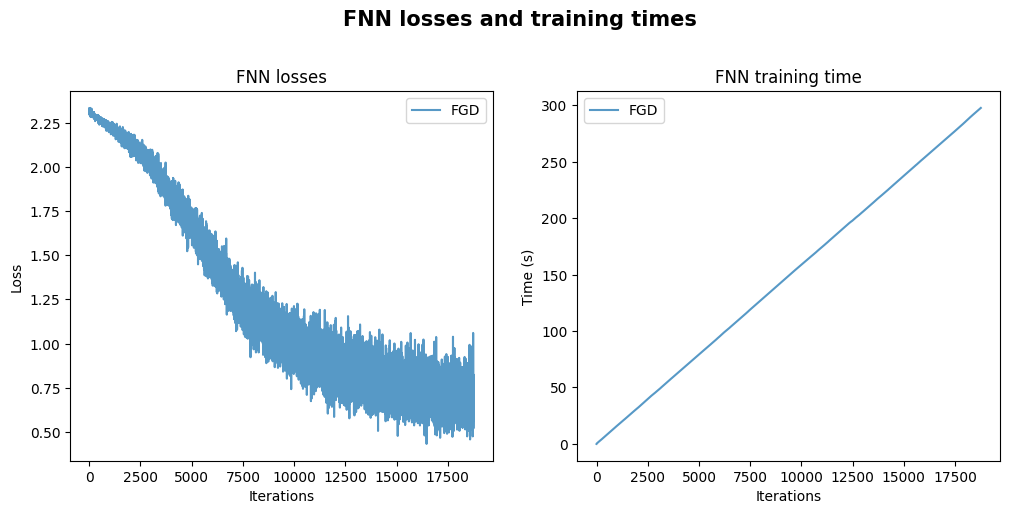

In [32]:
# Train FNN with FGD
fnn_fgd_l, fnn_fgd_t = train_fgd(FNN(), train_loader=train_loader, num_epochs=20)
# Train FNN with SGD
# fnn_sgd_l, fnn_sgd_t = train_sgd(FNN(), train_loader=train_loader, num_epochs=20)

# Set up a figure
fig = plt.figure(figsize=plt.figaspect(.4))
fig.suptitle("FNN losses and training times", fontsize=15, fontweight='bold', y=1.05)

# First subplot (Losses)
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("FNN losses")
ax1.plot(fnn_fgd_l, label='FGD', alpha=0.75)
# ax1.plot(fnn_sgd_l, label='SGD', alpha=0.75)
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Loss")
ax1.legend()

# Second subplot (Times)
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("FNN training time")
ax2.plot(fnn_fgd_t, label='FGD', alpha=0.75)
# ax2.plot(fnn_sgd_t, label='SGD', alpha=0.75)
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Time (s)")
ax2.legend()

plt.show()

C:\Users\MOSS_8192\AppData\Local\Temp\ipykernel_8840\2394295025.py:11: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  func, params = make_functional(model)




Training CNN with FGD for 50 epochs...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50],	Step [64/938],	Iteraion [64/46900],	Loss: 2.3012,	Time: 0.07
Epoch [1/50],	Step [128/938],	Iteraion [128/46900],	Loss: 2.3035,	Time: 0.06
Epoch [1/50],	Step [192/938],	Iteraion [192/46900],	Loss: 2.3041,	Time: 0.08
Epoch [1/50],	Step [256/938],	Iteraion [256/46900],	Loss: 2.3040,	Time: 0.06
Epoch [1/50],	Step [320/938],	Iteraion [320/46900],	Loss: 2.2963,	Time: 0.07
Epoch [1/50],	Step [384/938],	Iteraion [384/46900],	Loss: 2.3074,	Time: 0.07
Epoch [1/50],	Step [448/938],	Iteraion [448/46900],	Loss: 2.3010,	Time: 0.07
Epoch [1/50],	Step [512/938],	Iteraion [512/46900],	Loss: 2.3067,	Time: 0.06
Epoch [1/50],	Step [576/938],	Iteraion [576/46900],	Loss: 2.3051,	Time: 0.05
Epoch [1/50],	Step [640/938],	Iteraion [640/46900],	Loss: 2.3019,	Time: 0.07
Epoch [1/50],	Step [704/938],	Iteraion [704/46900],	Loss: 2.3002,	Time: 0.08
Epoch [1/50],	Step [768/938],	Iteraion [768/46900],	Loss: 2.3032,	Time: 0.07
Epoch [1/50],	Step [832/938],	Iteraion [832/46900],	Loss: 2.3050,	Time: 0.08
E

  2%|▏         | 1/50 [01:08<55:44, 68.25s/it]

Epoch [2/50],	Step [64/938],	Iteraion [1002/46900],	Loss: 2.3027,	Time: 0.05
Epoch [2/50],	Step [128/938],	Iteraion [1066/46900],	Loss: 2.3019,	Time: 0.05
Epoch [2/50],	Step [192/938],	Iteraion [1130/46900],	Loss: 2.3032,	Time: 0.07
Epoch [2/50],	Step [256/938],	Iteraion [1194/46900],	Loss: 2.2996,	Time: 0.08
Epoch [2/50],	Step [320/938],	Iteraion [1258/46900],	Loss: 2.3062,	Time: 0.07
Epoch [2/50],	Step [384/938],	Iteraion [1322/46900],	Loss: 2.3024,	Time: 0.07
Epoch [2/50],	Step [448/938],	Iteraion [1386/46900],	Loss: 2.3005,	Time: 0.07
Epoch [2/50],	Step [512/938],	Iteraion [1450/46900],	Loss: 2.3041,	Time: 0.05
Epoch [2/50],	Step [576/938],	Iteraion [1514/46900],	Loss: 2.3000,	Time: 0.06
Epoch [2/50],	Step [640/938],	Iteraion [1578/46900],	Loss: 2.3019,	Time: 0.06
Epoch [2/50],	Step [704/938],	Iteraion [1642/46900],	Loss: 2.2990,	Time: 0.06
Epoch [2/50],	Step [768/938],	Iteraion [1706/46900],	Loss: 2.3005,	Time: 0.05
Epoch [2/50],	Step [832/938],	Iteraion [1770/46900],	Loss: 2.3034

  4%|▍         | 2/50 [02:19<56:02, 70.06s/it]

Epoch [3/50],	Step [64/938],	Iteraion [1940/46900],	Loss: 2.3009,	Time: 0.05
Epoch [3/50],	Step [128/938],	Iteraion [2004/46900],	Loss: 2.2996,	Time: 0.06
Epoch [3/50],	Step [192/938],	Iteraion [2068/46900],	Loss: 2.2951,	Time: 0.07
Epoch [3/50],	Step [256/938],	Iteraion [2132/46900],	Loss: 2.3000,	Time: 0.07
Epoch [3/50],	Step [320/938],	Iteraion [2196/46900],	Loss: 2.2994,	Time: 0.05
Epoch [3/50],	Step [384/938],	Iteraion [2260/46900],	Loss: 2.3030,	Time: 0.07
Epoch [3/50],	Step [448/938],	Iteraion [2324/46900],	Loss: 2.3019,	Time: 0.07
Epoch [3/50],	Step [512/938],	Iteraion [2388/46900],	Loss: 2.3005,	Time: 0.05
Epoch [3/50],	Step [576/938],	Iteraion [2452/46900],	Loss: 2.2989,	Time: 0.06
Epoch [3/50],	Step [640/938],	Iteraion [2516/46900],	Loss: 2.3065,	Time: 0.07
Epoch [3/50],	Step [704/938],	Iteraion [2580/46900],	Loss: 2.3019,	Time: 0.07
Epoch [3/50],	Step [768/938],	Iteraion [2644/46900],	Loss: 2.2991,	Time: 0.07
Epoch [3/50],	Step [832/938],	Iteraion [2708/46900],	Loss: 2.3004

  6%|▌         | 3/50 [03:27<54:14, 69.25s/it]

Epoch [4/50],	Step [64/938],	Iteraion [2878/46900],	Loss: 2.3005,	Time: 0.07
Epoch [4/50],	Step [128/938],	Iteraion [2942/46900],	Loss: 2.2990,	Time: 0.07
Epoch [4/50],	Step [192/938],	Iteraion [3006/46900],	Loss: 2.2995,	Time: 0.06
Epoch [4/50],	Step [256/938],	Iteraion [3070/46900],	Loss: 2.3022,	Time: 0.05
Epoch [4/50],	Step [320/938],	Iteraion [3134/46900],	Loss: 2.3030,	Time: 0.07
Epoch [4/50],	Step [384/938],	Iteraion [3198/46900],	Loss: 2.2991,	Time: 0.07
Epoch [4/50],	Step [448/938],	Iteraion [3262/46900],	Loss: 2.2977,	Time: 0.05
Epoch [4/50],	Step [512/938],	Iteraion [3326/46900],	Loss: 2.2981,	Time: 0.05
Epoch [4/50],	Step [576/938],	Iteraion [3390/46900],	Loss: 2.2997,	Time: 0.07
Epoch [4/50],	Step [640/938],	Iteraion [3454/46900],	Loss: 2.2972,	Time: 0.07
Epoch [4/50],	Step [704/938],	Iteraion [3518/46900],	Loss: 2.2983,	Time: 0.06
Epoch [4/50],	Step [768/938],	Iteraion [3582/46900],	Loss: 2.2974,	Time: 0.05
Epoch [4/50],	Step [832/938],	Iteraion [3646/46900],	Loss: 2.3025

  8%|▊         | 4/50 [04:35<52:40, 68.70s/it]

Epoch [5/50],	Step [64/938],	Iteraion [3816/46900],	Loss: 2.3035,	Time: 0.05
Epoch [5/50],	Step [128/938],	Iteraion [3880/46900],	Loss: 2.2968,	Time: 0.07
Epoch [5/50],	Step [192/938],	Iteraion [3944/46900],	Loss: 2.2976,	Time: 0.06
Epoch [5/50],	Step [256/938],	Iteraion [4008/46900],	Loss: 2.2962,	Time: 0.06
Epoch [5/50],	Step [320/938],	Iteraion [4072/46900],	Loss: 2.2981,	Time: 0.06
Epoch [5/50],	Step [384/938],	Iteraion [4136/46900],	Loss: 2.3015,	Time: 0.06
Epoch [5/50],	Step [448/938],	Iteraion [4200/46900],	Loss: 2.2948,	Time: 0.07
Epoch [5/50],	Step [512/938],	Iteraion [4264/46900],	Loss: 2.2987,	Time: 0.05
Epoch [5/50],	Step [576/938],	Iteraion [4328/46900],	Loss: 2.2972,	Time: 0.05
Epoch [5/50],	Step [640/938],	Iteraion [4392/46900],	Loss: 2.3027,	Time: 0.06
Epoch [5/50],	Step [704/938],	Iteraion [4456/46900],	Loss: 2.3019,	Time: 0.07
Epoch [5/50],	Step [768/938],	Iteraion [4520/46900],	Loss: 2.2949,	Time: 0.07
Epoch [5/50],	Step [832/938],	Iteraion [4584/46900],	Loss: 2.3012

 10%|█         | 5/50 [05:43<51:18, 68.40s/it]

Epoch [6/50],	Step [64/938],	Iteraion [4754/46900],	Loss: 2.2989,	Time: 0.07
Epoch [6/50],	Step [128/938],	Iteraion [4818/46900],	Loss: 2.3047,	Time: 0.06
Epoch [6/50],	Step [192/938],	Iteraion [4882/46900],	Loss: 2.2996,	Time: 0.05
Epoch [6/50],	Step [256/938],	Iteraion [4946/46900],	Loss: 2.2976,	Time: 0.05
Epoch [6/50],	Step [320/938],	Iteraion [5010/46900],	Loss: 2.2999,	Time: 0.07
Epoch [6/50],	Step [384/938],	Iteraion [5074/46900],	Loss: 2.3000,	Time: 0.07
Epoch [6/50],	Step [448/938],	Iteraion [5138/46900],	Loss: 2.2981,	Time: 0.07
Epoch [6/50],	Step [512/938],	Iteraion [5202/46900],	Loss: 2.2996,	Time: 0.06
Epoch [6/50],	Step [576/938],	Iteraion [5266/46900],	Loss: 2.3006,	Time: 0.06
Epoch [6/50],	Step [640/938],	Iteraion [5330/46900],	Loss: 2.2977,	Time: 0.06
Epoch [6/50],	Step [704/938],	Iteraion [5394/46900],	Loss: 2.2974,	Time: 0.08
Epoch [6/50],	Step [768/938],	Iteraion [5458/46900],	Loss: 2.2981,	Time: 0.07
Epoch [6/50],	Step [832/938],	Iteraion [5522/46900],	Loss: 2.3013

 12%|█▏        | 6/50 [06:51<50:07, 68.36s/it]

Epoch [7/50],	Step [64/938],	Iteraion [5692/46900],	Loss: 2.3016,	Time: 0.05
Epoch [7/50],	Step [128/938],	Iteraion [5756/46900],	Loss: 2.2931,	Time: 0.05
Epoch [7/50],	Step [192/938],	Iteraion [5820/46900],	Loss: 2.2972,	Time: 0.05
Epoch [7/50],	Step [256/938],	Iteraion [5884/46900],	Loss: 2.2971,	Time: 0.07
Epoch [7/50],	Step [320/938],	Iteraion [5948/46900],	Loss: 2.2999,	Time: 0.07
Epoch [7/50],	Step [384/938],	Iteraion [6012/46900],	Loss: 2.2970,	Time: 0.05
Epoch [7/50],	Step [448/938],	Iteraion [6076/46900],	Loss: 2.2961,	Time: 0.07
Epoch [7/50],	Step [512/938],	Iteraion [6140/46900],	Loss: 2.2969,	Time: 0.08
Epoch [7/50],	Step [576/938],	Iteraion [6204/46900],	Loss: 2.2948,	Time: 0.07
Epoch [7/50],	Step [640/938],	Iteraion [6268/46900],	Loss: 2.2954,	Time: 0.05
Epoch [7/50],	Step [704/938],	Iteraion [6332/46900],	Loss: 2.3031,	Time: 0.07
Epoch [7/50],	Step [768/938],	Iteraion [6396/46900],	Loss: 2.2971,	Time: 0.07
Epoch [7/50],	Step [832/938],	Iteraion [6460/46900],	Loss: 2.2991

 14%|█▍        | 7/50 [07:59<48:55, 68.27s/it]

Epoch [8/50],	Step [64/938],	Iteraion [6630/46900],	Loss: 2.2955,	Time: 0.06
Epoch [8/50],	Step [128/938],	Iteraion [6694/46900],	Loss: 2.3003,	Time: 0.06
Epoch [8/50],	Step [192/938],	Iteraion [6758/46900],	Loss: 2.2987,	Time: 0.07
Epoch [8/50],	Step [256/938],	Iteraion [6822/46900],	Loss: 2.2964,	Time: 0.06
Epoch [8/50],	Step [320/938],	Iteraion [6886/46900],	Loss: 2.3045,	Time: 0.06
Epoch [8/50],	Step [384/938],	Iteraion [6950/46900],	Loss: 2.3002,	Time: 0.07
Epoch [8/50],	Step [448/938],	Iteraion [7014/46900],	Loss: 2.2986,	Time: 0.07
Epoch [8/50],	Step [512/938],	Iteraion [7078/46900],	Loss: 2.2959,	Time: 0.07
Epoch [8/50],	Step [576/938],	Iteraion [7142/46900],	Loss: 2.2935,	Time: 0.07
Epoch [8/50],	Step [640/938],	Iteraion [7206/46900],	Loss: 2.2990,	Time: 0.07
Epoch [8/50],	Step [704/938],	Iteraion [7270/46900],	Loss: 2.2929,	Time: 0.07
Epoch [8/50],	Step [768/938],	Iteraion [7334/46900],	Loss: 2.3011,	Time: 0.08
Epoch [8/50],	Step [832/938],	Iteraion [7398/46900],	Loss: 2.2917

 16%|█▌        | 8/50 [09:14<49:13, 70.32s/it]

Epoch [9/50],	Step [64/938],	Iteraion [7568/46900],	Loss: 2.2990,	Time: 0.07
Epoch [9/50],	Step [128/938],	Iteraion [7632/46900],	Loss: 2.3006,	Time: 0.07
Epoch [9/50],	Step [192/938],	Iteraion [7696/46900],	Loss: 2.2949,	Time: 0.07
Epoch [9/50],	Step [256/938],	Iteraion [7760/46900],	Loss: 2.2952,	Time: 0.07
Epoch [9/50],	Step [320/938],	Iteraion [7824/46900],	Loss: 2.3001,	Time: 0.07
Epoch [9/50],	Step [384/938],	Iteraion [7888/46900],	Loss: 2.2988,	Time: 0.08
Epoch [9/50],	Step [448/938],	Iteraion [7952/46900],	Loss: 2.2968,	Time: 0.07
Epoch [9/50],	Step [512/938],	Iteraion [8016/46900],	Loss: 2.3029,	Time: 0.07
Epoch [9/50],	Step [576/938],	Iteraion [8080/46900],	Loss: 2.2988,	Time: 0.07
Epoch [9/50],	Step [640/938],	Iteraion [8144/46900],	Loss: 2.2970,	Time: 0.08
Epoch [9/50],	Step [704/938],	Iteraion [8208/46900],	Loss: 2.3005,	Time: 0.08
Epoch [9/50],	Step [768/938],	Iteraion [8272/46900],	Loss: 2.2970,	Time: 0.07
Epoch [9/50],	Step [832/938],	Iteraion [8336/46900],	Loss: 2.2987

 18%|█▊        | 9/50 [10:34<50:01, 73.20s/it]

Epoch [10/50],	Step [64/938],	Iteraion [8506/46900],	Loss: 2.2930,	Time: 0.07
Epoch [10/50],	Step [128/938],	Iteraion [8570/46900],	Loss: 2.2952,	Time: 0.07
Epoch [10/50],	Step [192/938],	Iteraion [8634/46900],	Loss: 2.2990,	Time: 0.07
Epoch [10/50],	Step [256/938],	Iteraion [8698/46900],	Loss: 2.2995,	Time: 0.07
Epoch [10/50],	Step [320/938],	Iteraion [8762/46900],	Loss: 2.2947,	Time: 0.08
Epoch [10/50],	Step [384/938],	Iteraion [8826/46900],	Loss: 2.3000,	Time: 0.07
Epoch [10/50],	Step [448/938],	Iteraion [8890/46900],	Loss: 2.2976,	Time: 0.07
Epoch [10/50],	Step [512/938],	Iteraion [8954/46900],	Loss: 2.3010,	Time: 0.08
Epoch [10/50],	Step [576/938],	Iteraion [9018/46900],	Loss: 2.3011,	Time: 0.08
Epoch [10/50],	Step [640/938],	Iteraion [9082/46900],	Loss: 2.2946,	Time: 0.07
Epoch [10/50],	Step [704/938],	Iteraion [9146/46900],	Loss: 2.2990,	Time: 0.08
Epoch [10/50],	Step [768/938],	Iteraion [9210/46900],	Loss: 2.2998,	Time: 0.08
Epoch [10/50],	Step [832/938],	Iteraion [9274/46900],

 20%|██        | 10/50 [11:53<50:08, 75.22s/it]

Epoch [11/50],	Step [64/938],	Iteraion [9444/46900],	Loss: 2.3000,	Time: 0.07
Epoch [11/50],	Step [128/938],	Iteraion [9508/46900],	Loss: 2.2999,	Time: 0.08
Epoch [11/50],	Step [192/938],	Iteraion [9572/46900],	Loss: 2.2897,	Time: 0.07
Epoch [11/50],	Step [256/938],	Iteraion [9636/46900],	Loss: 2.2913,	Time: 0.07
Epoch [11/50],	Step [320/938],	Iteraion [9700/46900],	Loss: 2.2981,	Time: 0.07
Epoch [11/50],	Step [384/938],	Iteraion [9764/46900],	Loss: 2.2972,	Time: 0.07
Epoch [11/50],	Step [448/938],	Iteraion [9828/46900],	Loss: 2.2962,	Time: 0.07
Epoch [11/50],	Step [512/938],	Iteraion [9892/46900],	Loss: 2.3015,	Time: 0.07
Epoch [11/50],	Step [576/938],	Iteraion [9956/46900],	Loss: 2.2953,	Time: 0.08
Epoch [11/50],	Step [640/938],	Iteraion [10020/46900],	Loss: 2.2961,	Time: 0.07
Epoch [11/50],	Step [704/938],	Iteraion [10084/46900],	Loss: 2.2969,	Time: 0.07
Epoch [11/50],	Step [768/938],	Iteraion [10148/46900],	Loss: 2.3004,	Time: 0.08
Epoch [11/50],	Step [832/938],	Iteraion [10212/469

 22%|██▏       | 11/50 [13:13<49:46, 76.57s/it]

Epoch [12/50],	Step [64/938],	Iteraion [10382/46900],	Loss: 2.2965,	Time: 0.07
Epoch [12/50],	Step [128/938],	Iteraion [10446/46900],	Loss: 2.2926,	Time: 0.07
Epoch [12/50],	Step [192/938],	Iteraion [10510/46900],	Loss: 2.2994,	Time: 0.08
Epoch [12/50],	Step [256/938],	Iteraion [10574/46900],	Loss: 2.2978,	Time: 0.08
Epoch [12/50],	Step [320/938],	Iteraion [10638/46900],	Loss: 2.2975,	Time: 0.08
Epoch [12/50],	Step [384/938],	Iteraion [10702/46900],	Loss: 2.2911,	Time: 0.08
Epoch [12/50],	Step [448/938],	Iteraion [10766/46900],	Loss: 2.2939,	Time: 0.07
Epoch [12/50],	Step [512/938],	Iteraion [10830/46900],	Loss: 2.2977,	Time: 0.08
Epoch [12/50],	Step [576/938],	Iteraion [10894/46900],	Loss: 2.2963,	Time: 0.08
Epoch [12/50],	Step [640/938],	Iteraion [10958/46900],	Loss: 2.2925,	Time: 0.07
Epoch [12/50],	Step [704/938],	Iteraion [11022/46900],	Loss: 2.2971,	Time: 0.07
Epoch [12/50],	Step [768/938],	Iteraion [11086/46900],	Loss: 2.2941,	Time: 0.08
Epoch [12/50],	Step [832/938],	Iteraion [

 24%|██▍       | 12/50 [14:33<49:05, 77.51s/it]

Epoch [13/50],	Step [64/938],	Iteraion [11320/46900],	Loss: 2.2976,	Time: 0.07
Epoch [13/50],	Step [128/938],	Iteraion [11384/46900],	Loss: 2.3003,	Time: 0.07
Epoch [13/50],	Step [192/938],	Iteraion [11448/46900],	Loss: 2.2972,	Time: 0.07
Epoch [13/50],	Step [256/938],	Iteraion [11512/46900],	Loss: 2.2965,	Time: 0.07
Epoch [13/50],	Step [320/938],	Iteraion [11576/46900],	Loss: 2.3007,	Time: 0.08
Epoch [13/50],	Step [384/938],	Iteraion [11640/46900],	Loss: 2.2958,	Time: 0.07
Epoch [13/50],	Step [448/938],	Iteraion [11704/46900],	Loss: 2.2954,	Time: 0.07
Epoch [13/50],	Step [512/938],	Iteraion [11768/46900],	Loss: 2.2919,	Time: 0.08
Epoch [13/50],	Step [576/938],	Iteraion [11832/46900],	Loss: 2.2922,	Time: 0.07
Epoch [13/50],	Step [640/938],	Iteraion [11896/46900],	Loss: 2.2952,	Time: 0.07
Epoch [13/50],	Step [704/938],	Iteraion [11960/46900],	Loss: 2.2954,	Time: 0.07
Epoch [13/50],	Step [768/938],	Iteraion [12024/46900],	Loss: 2.2991,	Time: 0.08
Epoch [13/50],	Step [832/938],	Iteraion [

 26%|██▌       | 13/50 [15:52<48:11, 78.15s/it]

Epoch [14/50],	Step [64/938],	Iteraion [12258/46900],	Loss: 2.2948,	Time: 0.07
Epoch [14/50],	Step [128/938],	Iteraion [12322/46900],	Loss: 2.2927,	Time: 0.07
Epoch [14/50],	Step [192/938],	Iteraion [12386/46900],	Loss: 2.2938,	Time: 0.07
Epoch [14/50],	Step [256/938],	Iteraion [12450/46900],	Loss: 2.2916,	Time: 0.08
Epoch [14/50],	Step [320/938],	Iteraion [12514/46900],	Loss: 2.2952,	Time: 0.07
Epoch [14/50],	Step [384/938],	Iteraion [12578/46900],	Loss: 2.2980,	Time: 0.08
Epoch [14/50],	Step [448/938],	Iteraion [12642/46900],	Loss: 2.2967,	Time: 0.07
Epoch [14/50],	Step [512/938],	Iteraion [12706/46900],	Loss: 2.2959,	Time: 0.07
Epoch [14/50],	Step [576/938],	Iteraion [12770/46900],	Loss: 2.2943,	Time: 0.07
Epoch [14/50],	Step [640/938],	Iteraion [12834/46900],	Loss: 2.2953,	Time: 0.07
Epoch [14/50],	Step [704/938],	Iteraion [12898/46900],	Loss: 2.2965,	Time: 0.08
Epoch [14/50],	Step [768/938],	Iteraion [12962/46900],	Loss: 2.2965,	Time: 0.07
Epoch [14/50],	Step [832/938],	Iteraion [

 28%|██▊       | 14/50 [17:12<47:09, 78.61s/it]

Epoch [15/50],	Step [64/938],	Iteraion [13196/46900],	Loss: 2.2946,	Time: 0.08
Epoch [15/50],	Step [128/938],	Iteraion [13260/46900],	Loss: 2.2923,	Time: 0.08
Epoch [15/50],	Step [192/938],	Iteraion [13324/46900],	Loss: 2.2940,	Time: 0.07
Epoch [15/50],	Step [256/938],	Iteraion [13388/46900],	Loss: 2.2928,	Time: 0.07
Epoch [15/50],	Step [320/938],	Iteraion [13452/46900],	Loss: 2.2943,	Time: 0.07
Epoch [15/50],	Step [384/938],	Iteraion [13516/46900],	Loss: 2.2927,	Time: 0.07
Epoch [15/50],	Step [448/938],	Iteraion [13580/46900],	Loss: 2.2947,	Time: 0.07
Epoch [15/50],	Step [512/938],	Iteraion [13644/46900],	Loss: 2.2954,	Time: 0.07
Epoch [15/50],	Step [576/938],	Iteraion [13708/46900],	Loss: 2.2963,	Time: 0.08
Epoch [15/50],	Step [640/938],	Iteraion [13772/46900],	Loss: 2.2988,	Time: 0.08
Epoch [15/50],	Step [704/938],	Iteraion [13836/46900],	Loss: 2.2950,	Time: 0.08
Epoch [15/50],	Step [768/938],	Iteraion [13900/46900],	Loss: 2.2971,	Time: 0.08
Epoch [15/50],	Step [832/938],	Iteraion [

 30%|███       | 15/50 [18:32<46:02, 78.92s/it]

Epoch [16/50],	Step [64/938],	Iteraion [14134/46900],	Loss: 2.2884,	Time: 0.08
Epoch [16/50],	Step [128/938],	Iteraion [14198/46900],	Loss: 2.2979,	Time: 0.08
Epoch [16/50],	Step [192/938],	Iteraion [14262/46900],	Loss: 2.2982,	Time: 0.07
Epoch [16/50],	Step [256/938],	Iteraion [14326/46900],	Loss: 2.2900,	Time: 0.07
Epoch [16/50],	Step [320/938],	Iteraion [14390/46900],	Loss: 2.2959,	Time: 0.08
Epoch [16/50],	Step [384/938],	Iteraion [14454/46900],	Loss: 2.2926,	Time: 0.08
Epoch [16/50],	Step [448/938],	Iteraion [14518/46900],	Loss: 2.2977,	Time: 0.07
Epoch [16/50],	Step [512/938],	Iteraion [14582/46900],	Loss: 2.2915,	Time: 0.07
Epoch [16/50],	Step [576/938],	Iteraion [14646/46900],	Loss: 2.2953,	Time: 0.07
Epoch [16/50],	Step [640/938],	Iteraion [14710/46900],	Loss: 2.2972,	Time: 0.07
Epoch [16/50],	Step [704/938],	Iteraion [14774/46900],	Loss: 2.2948,	Time: 0.07
Epoch [16/50],	Step [768/938],	Iteraion [14838/46900],	Loss: 2.2937,	Time: 0.07
Epoch [16/50],	Step [832/938],	Iteraion [

 32%|███▏      | 16/50 [19:51<44:51, 79.17s/it]

Epoch [17/50],	Step [64/938],	Iteraion [15072/46900],	Loss: 2.2955,	Time: 0.08
Epoch [17/50],	Step [128/938],	Iteraion [15136/46900],	Loss: 2.2997,	Time: 0.07
Epoch [17/50],	Step [192/938],	Iteraion [15200/46900],	Loss: 2.2956,	Time: 0.08
Epoch [17/50],	Step [256/938],	Iteraion [15264/46900],	Loss: 2.2936,	Time: 0.07
Epoch [17/50],	Step [320/938],	Iteraion [15328/46900],	Loss: 2.2928,	Time: 0.08
Epoch [17/50],	Step [384/938],	Iteraion [15392/46900],	Loss: 2.2961,	Time: 0.08
Epoch [17/50],	Step [448/938],	Iteraion [15456/46900],	Loss: 2.2949,	Time: 0.07
Epoch [17/50],	Step [512/938],	Iteraion [15520/46900],	Loss: 2.2896,	Time: 0.07
Epoch [17/50],	Step [576/938],	Iteraion [15584/46900],	Loss: 2.2970,	Time: 0.07
Epoch [17/50],	Step [640/938],	Iteraion [15648/46900],	Loss: 2.2966,	Time: 0.07
Epoch [17/50],	Step [704/938],	Iteraion [15712/46900],	Loss: 2.2962,	Time: 0.07
Epoch [17/50],	Step [768/938],	Iteraion [15776/46900],	Loss: 2.2911,	Time: 0.07
Epoch [17/50],	Step [832/938],	Iteraion [

 34%|███▍      | 17/50 [21:11<43:36, 79.28s/it]

Epoch [18/50],	Step [64/938],	Iteraion [16010/46900],	Loss: 2.2957,	Time: 0.07
Epoch [18/50],	Step [128/938],	Iteraion [16074/46900],	Loss: 2.2944,	Time: 0.07
Epoch [18/50],	Step [192/938],	Iteraion [16138/46900],	Loss: 2.2989,	Time: 0.08
Epoch [18/50],	Step [256/938],	Iteraion [16202/46900],	Loss: 2.2931,	Time: 0.07
Epoch [18/50],	Step [320/938],	Iteraion [16266/46900],	Loss: 2.2985,	Time: 0.08
Epoch [18/50],	Step [384/938],	Iteraion [16330/46900],	Loss: 2.2934,	Time: 0.07
Epoch [18/50],	Step [448/938],	Iteraion [16394/46900],	Loss: 2.2897,	Time: 0.07
Epoch [18/50],	Step [512/938],	Iteraion [16458/46900],	Loss: 2.2973,	Time: 0.07
Epoch [18/50],	Step [576/938],	Iteraion [16522/46900],	Loss: 2.2990,	Time: 0.07
Epoch [18/50],	Step [640/938],	Iteraion [16586/46900],	Loss: 2.2985,	Time: 0.07
Epoch [18/50],	Step [704/938],	Iteraion [16650/46900],	Loss: 2.2934,	Time: 0.07
Epoch [18/50],	Step [768/938],	Iteraion [16714/46900],	Loss: 2.3004,	Time: 0.07
Epoch [18/50],	Step [832/938],	Iteraion [

 36%|███▌      | 18/50 [22:31<42:19, 79.37s/it]

Epoch [19/50],	Step [64/938],	Iteraion [16948/46900],	Loss: 2.2924,	Time: 0.07
Epoch [19/50],	Step [128/938],	Iteraion [17012/46900],	Loss: 2.3017,	Time: 0.07
Epoch [19/50],	Step [192/938],	Iteraion [17076/46900],	Loss: 2.2933,	Time: 0.08
Epoch [19/50],	Step [256/938],	Iteraion [17140/46900],	Loss: 2.2949,	Time: 0.07
Epoch [19/50],	Step [320/938],	Iteraion [17204/46900],	Loss: 2.2881,	Time: 0.08
Epoch [19/50],	Step [384/938],	Iteraion [17268/46900],	Loss: 2.2964,	Time: 0.07
Epoch [19/50],	Step [448/938],	Iteraion [17332/46900],	Loss: 2.2921,	Time: 0.07
Epoch [19/50],	Step [512/938],	Iteraion [17396/46900],	Loss: 2.2939,	Time: 0.07
Epoch [19/50],	Step [576/938],	Iteraion [17460/46900],	Loss: 2.2970,	Time: 0.07
Epoch [19/50],	Step [640/938],	Iteraion [17524/46900],	Loss: 2.2895,	Time: 0.07
Epoch [19/50],	Step [704/938],	Iteraion [17588/46900],	Loss: 2.2950,	Time: 0.07
Epoch [19/50],	Step [768/938],	Iteraion [17652/46900],	Loss: 2.2968,	Time: 0.07
Epoch [19/50],	Step [832/938],	Iteraion [

 38%|███▊      | 19/50 [23:50<41:03, 79.45s/it]

Epoch [20/50],	Step [64/938],	Iteraion [17886/46900],	Loss: 2.2944,	Time: 0.08
Epoch [20/50],	Step [128/938],	Iteraion [17950/46900],	Loss: 2.2912,	Time: 0.08
Epoch [20/50],	Step [192/938],	Iteraion [18014/46900],	Loss: 2.2925,	Time: 0.07
Epoch [20/50],	Step [256/938],	Iteraion [18078/46900],	Loss: 2.2956,	Time: 0.07
Epoch [20/50],	Step [320/938],	Iteraion [18142/46900],	Loss: 2.2936,	Time: 0.07
Epoch [20/50],	Step [384/938],	Iteraion [18206/46900],	Loss: 2.2956,	Time: 0.08
Epoch [20/50],	Step [448/938],	Iteraion [18270/46900],	Loss: 2.2952,	Time: 0.08
Epoch [20/50],	Step [512/938],	Iteraion [18334/46900],	Loss: 2.2936,	Time: 0.07
Epoch [20/50],	Step [576/938],	Iteraion [18398/46900],	Loss: 2.2946,	Time: 0.07
Epoch [20/50],	Step [640/938],	Iteraion [18462/46900],	Loss: 2.2919,	Time: 0.08
Epoch [20/50],	Step [704/938],	Iteraion [18526/46900],	Loss: 2.2937,	Time: 0.08
Epoch [20/50],	Step [768/938],	Iteraion [18590/46900],	Loss: 2.2999,	Time: 0.08
Epoch [20/50],	Step [832/938],	Iteraion [

 40%|████      | 20/50 [25:10<39:46, 79.53s/it]

Epoch [21/50],	Step [64/938],	Iteraion [18824/46900],	Loss: 2.2935,	Time: 0.08
Epoch [21/50],	Step [128/938],	Iteraion [18888/46900],	Loss: 2.2964,	Time: 0.07
Epoch [21/50],	Step [192/938],	Iteraion [18952/46900],	Loss: 2.2979,	Time: 0.08
Epoch [21/50],	Step [256/938],	Iteraion [19016/46900],	Loss: 2.2937,	Time: 0.07
Epoch [21/50],	Step [320/938],	Iteraion [19080/46900],	Loss: 2.2932,	Time: 0.07
Epoch [21/50],	Step [384/938],	Iteraion [19144/46900],	Loss: 2.3001,	Time: 0.07
Epoch [21/50],	Step [448/938],	Iteraion [19208/46900],	Loss: 2.2953,	Time: 0.07
Epoch [21/50],	Step [512/938],	Iteraion [19272/46900],	Loss: 2.2959,	Time: 0.07
Epoch [21/50],	Step [576/938],	Iteraion [19336/46900],	Loss: 2.2969,	Time: 0.08
Epoch [21/50],	Step [640/938],	Iteraion [19400/46900],	Loss: 2.2943,	Time: 0.07
Epoch [21/50],	Step [704/938],	Iteraion [19464/46900],	Loss: 2.2972,	Time: 0.07
Epoch [21/50],	Step [768/938],	Iteraion [19528/46900],	Loss: 2.2957,	Time: 0.08
Epoch [21/50],	Step [832/938],	Iteraion [

 42%|████▏     | 21/50 [26:30<38:29, 79.64s/it]

Epoch [22/50],	Step [64/938],	Iteraion [19762/46900],	Loss: 2.2938,	Time: 0.07
Epoch [22/50],	Step [128/938],	Iteraion [19826/46900],	Loss: 2.2942,	Time: 0.07
Epoch [22/50],	Step [192/938],	Iteraion [19890/46900],	Loss: 2.2960,	Time: 0.07
Epoch [22/50],	Step [256/938],	Iteraion [19954/46900],	Loss: 2.2890,	Time: 0.08
Epoch [22/50],	Step [320/938],	Iteraion [20018/46900],	Loss: 2.2957,	Time: 0.08
Epoch [22/50],	Step [384/938],	Iteraion [20082/46900],	Loss: 2.2995,	Time: 0.07
Epoch [22/50],	Step [448/938],	Iteraion [20146/46900],	Loss: 2.2934,	Time: 0.07
Epoch [22/50],	Step [512/938],	Iteraion [20210/46900],	Loss: 2.2878,	Time: 0.07
Epoch [22/50],	Step [576/938],	Iteraion [20274/46900],	Loss: 2.2874,	Time: 0.07
Epoch [22/50],	Step [640/938],	Iteraion [20338/46900],	Loss: 2.2929,	Time: 0.07
Epoch [22/50],	Step [704/938],	Iteraion [20402/46900],	Loss: 2.2877,	Time: 0.08
Epoch [22/50],	Step [768/938],	Iteraion [20466/46900],	Loss: 2.2981,	Time: 0.08
Epoch [22/50],	Step [832/938],	Iteraion [

 44%|████▍     | 22/50 [27:49<37:09, 79.63s/it]

Epoch [23/50],	Step [64/938],	Iteraion [20700/46900],	Loss: 2.2947,	Time: 0.07
Epoch [23/50],	Step [128/938],	Iteraion [20764/46900],	Loss: 2.2924,	Time: 0.07
Epoch [23/50],	Step [192/938],	Iteraion [20828/46900],	Loss: 2.2874,	Time: 0.07
Epoch [23/50],	Step [256/938],	Iteraion [20892/46900],	Loss: 2.2970,	Time: 0.07
Epoch [23/50],	Step [320/938],	Iteraion [20956/46900],	Loss: 2.2981,	Time: 0.07
Epoch [23/50],	Step [384/938],	Iteraion [21020/46900],	Loss: 2.2969,	Time: 0.07
Epoch [23/50],	Step [448/938],	Iteraion [21084/46900],	Loss: 2.2931,	Time: 0.08
Epoch [23/50],	Step [512/938],	Iteraion [21148/46900],	Loss: 2.2926,	Time: 0.07
Epoch [23/50],	Step [576/938],	Iteraion [21212/46900],	Loss: 2.2944,	Time: 0.07
Epoch [23/50],	Step [640/938],	Iteraion [21276/46900],	Loss: 2.2921,	Time: 0.08
Epoch [23/50],	Step [704/938],	Iteraion [21340/46900],	Loss: 2.2997,	Time: 0.07
Epoch [23/50],	Step [768/938],	Iteraion [21404/46900],	Loss: 2.2950,	Time: 0.07
Epoch [23/50],	Step [832/938],	Iteraion [

 46%|████▌     | 23/50 [29:09<35:50, 79.64s/it]

Epoch [24/50],	Step [64/938],	Iteraion [21638/46900],	Loss: 2.2936,	Time: 0.07
Epoch [24/50],	Step [128/938],	Iteraion [21702/46900],	Loss: 2.2919,	Time: 0.07
Epoch [24/50],	Step [192/938],	Iteraion [21766/46900],	Loss: 2.2949,	Time: 0.07
Epoch [24/50],	Step [256/938],	Iteraion [21830/46900],	Loss: 2.2931,	Time: 0.08
Epoch [24/50],	Step [320/938],	Iteraion [21894/46900],	Loss: 2.2969,	Time: 0.07
Epoch [24/50],	Step [384/938],	Iteraion [21958/46900],	Loss: 2.2865,	Time: 0.08
Epoch [24/50],	Step [448/938],	Iteraion [22022/46900],	Loss: 2.2955,	Time: 0.08
Epoch [24/50],	Step [512/938],	Iteraion [22086/46900],	Loss: 2.2906,	Time: 0.06
Epoch [24/50],	Step [576/938],	Iteraion [22150/46900],	Loss: 2.2967,	Time: 0.08
Epoch [24/50],	Step [640/938],	Iteraion [22214/46900],	Loss: 2.2973,	Time: 0.07
Epoch [24/50],	Step [704/938],	Iteraion [22278/46900],	Loss: 2.2942,	Time: 0.07
Epoch [24/50],	Step [768/938],	Iteraion [22342/46900],	Loss: 2.2937,	Time: 0.08
Epoch [24/50],	Step [832/938],	Iteraion [

 48%|████▊     | 24/50 [30:29<34:29, 79.60s/it]

Epoch [25/50],	Step [64/938],	Iteraion [22576/46900],	Loss: 2.2928,	Time: 0.08
Epoch [25/50],	Step [128/938],	Iteraion [22640/46900],	Loss: 2.2943,	Time: 0.08
Epoch [25/50],	Step [192/938],	Iteraion [22704/46900],	Loss: 2.2970,	Time: 0.07
Epoch [25/50],	Step [256/938],	Iteraion [22768/46900],	Loss: 2.2899,	Time: 0.07
Epoch [25/50],	Step [320/938],	Iteraion [22832/46900],	Loss: 2.2959,	Time: 0.07
Epoch [25/50],	Step [384/938],	Iteraion [22896/46900],	Loss: 2.2880,	Time: 0.07
Epoch [25/50],	Step [448/938],	Iteraion [22960/46900],	Loss: 2.2981,	Time: 0.07
Epoch [25/50],	Step [512/938],	Iteraion [23024/46900],	Loss: 2.2941,	Time: 0.07
Epoch [25/50],	Step [576/938],	Iteraion [23088/46900],	Loss: 2.2953,	Time: 0.07
Epoch [25/50],	Step [640/938],	Iteraion [23152/46900],	Loss: 2.2915,	Time: 0.07
Epoch [25/50],	Step [704/938],	Iteraion [23216/46900],	Loss: 2.2913,	Time: 0.06
Epoch [25/50],	Step [768/938],	Iteraion [23280/46900],	Loss: 2.2912,	Time: 0.07
Epoch [25/50],	Step [832/938],	Iteraion [

 50%|█████     | 25/50 [31:48<33:11, 79.64s/it]

Epoch [26/50],	Step [64/938],	Iteraion [23514/46900],	Loss: 2.2929,	Time: 0.07
Epoch [26/50],	Step [128/938],	Iteraion [23578/46900],	Loss: 2.2938,	Time: 0.08
Epoch [26/50],	Step [192/938],	Iteraion [23642/46900],	Loss: 2.2899,	Time: 0.08
Epoch [26/50],	Step [256/938],	Iteraion [23706/46900],	Loss: 2.2925,	Time: 0.07
Epoch [26/50],	Step [320/938],	Iteraion [23770/46900],	Loss: 2.2927,	Time: 0.07
Epoch [26/50],	Step [384/938],	Iteraion [23834/46900],	Loss: 2.2883,	Time: 0.07
Epoch [26/50],	Step [448/938],	Iteraion [23898/46900],	Loss: 2.2934,	Time: 0.07
Epoch [26/50],	Step [512/938],	Iteraion [23962/46900],	Loss: 2.2864,	Time: 0.07
Epoch [26/50],	Step [576/938],	Iteraion [24026/46900],	Loss: 2.2965,	Time: 0.07
Epoch [26/50],	Step [640/938],	Iteraion [24090/46900],	Loss: 2.2912,	Time: 0.07
Epoch [26/50],	Step [704/938],	Iteraion [24154/46900],	Loss: 2.2926,	Time: 0.07
Epoch [26/50],	Step [768/938],	Iteraion [24218/46900],	Loss: 2.2961,	Time: 0.07
Epoch [26/50],	Step [832/938],	Iteraion [

 52%|█████▏    | 26/50 [33:08<31:51, 79.65s/it]

Epoch [27/50],	Step [64/938],	Iteraion [24452/46900],	Loss: 2.2918,	Time: 0.08
Epoch [27/50],	Step [128/938],	Iteraion [24516/46900],	Loss: 2.2946,	Time: 0.08
Epoch [27/50],	Step [192/938],	Iteraion [24580/46900],	Loss: 2.2929,	Time: 0.07
Epoch [27/50],	Step [256/938],	Iteraion [24644/46900],	Loss: 2.2927,	Time: 0.08
Epoch [27/50],	Step [320/938],	Iteraion [24708/46900],	Loss: 2.2901,	Time: 0.07
Epoch [27/50],	Step [384/938],	Iteraion [24772/46900],	Loss: 2.2965,	Time: 0.07
Epoch [27/50],	Step [448/938],	Iteraion [24836/46900],	Loss: 2.2933,	Time: 0.08
Epoch [27/50],	Step [512/938],	Iteraion [24900/46900],	Loss: 2.2955,	Time: 0.08
Epoch [27/50],	Step [576/938],	Iteraion [24964/46900],	Loss: 2.2896,	Time: 0.07
Epoch [27/50],	Step [640/938],	Iteraion [25028/46900],	Loss: 2.2896,	Time: 0.07
Epoch [27/50],	Step [704/938],	Iteraion [25092/46900],	Loss: 2.2925,	Time: 0.07
Epoch [27/50],	Step [768/938],	Iteraion [25156/46900],	Loss: 2.2972,	Time: 0.07
Epoch [27/50],	Step [832/938],	Iteraion [

 54%|█████▍    | 27/50 [34:28<30:33, 79.70s/it]

Epoch [28/50],	Step [64/938],	Iteraion [25390/46900],	Loss: 2.2898,	Time: 0.07
Epoch [28/50],	Step [128/938],	Iteraion [25454/46900],	Loss: 2.2911,	Time: 0.08
Epoch [28/50],	Step [192/938],	Iteraion [25518/46900],	Loss: 2.2973,	Time: 0.07
Epoch [28/50],	Step [256/938],	Iteraion [25582/46900],	Loss: 2.2915,	Time: 0.07
Epoch [28/50],	Step [320/938],	Iteraion [25646/46900],	Loss: 2.2898,	Time: 0.07
Epoch [28/50],	Step [384/938],	Iteraion [25710/46900],	Loss: 2.2932,	Time: 0.07
Epoch [28/50],	Step [448/938],	Iteraion [25774/46900],	Loss: 2.2944,	Time: 0.07
Epoch [28/50],	Step [512/938],	Iteraion [25838/46900],	Loss: 2.2911,	Time: 0.07
Epoch [28/50],	Step [576/938],	Iteraion [25902/46900],	Loss: 2.2907,	Time: 0.08
Epoch [28/50],	Step [640/938],	Iteraion [25966/46900],	Loss: 2.2920,	Time: 0.08
Epoch [28/50],	Step [704/938],	Iteraion [26030/46900],	Loss: 2.2954,	Time: 0.06
Epoch [28/50],	Step [768/938],	Iteraion [26094/46900],	Loss: 2.2938,	Time: 0.07
Epoch [28/50],	Step [832/938],	Iteraion [

 56%|█████▌    | 28/50 [35:47<29:12, 79.68s/it]

Epoch [29/50],	Step [64/938],	Iteraion [26328/46900],	Loss: 2.2980,	Time: 0.07
Epoch [29/50],	Step [128/938],	Iteraion [26392/46900],	Loss: 2.2888,	Time: 0.07
Epoch [29/50],	Step [192/938],	Iteraion [26456/46900],	Loss: 2.2940,	Time: 0.07
Epoch [29/50],	Step [256/938],	Iteraion [26520/46900],	Loss: 2.2956,	Time: 0.07
Epoch [29/50],	Step [320/938],	Iteraion [26584/46900],	Loss: 2.2923,	Time: 0.07
Epoch [29/50],	Step [384/938],	Iteraion [26648/46900],	Loss: 2.2921,	Time: 0.08
Epoch [29/50],	Step [448/938],	Iteraion [26712/46900],	Loss: 2.2944,	Time: 0.07
Epoch [29/50],	Step [512/938],	Iteraion [26776/46900],	Loss: 2.2926,	Time: 0.08
Epoch [29/50],	Step [576/938],	Iteraion [26840/46900],	Loss: 2.2924,	Time: 0.07
Epoch [29/50],	Step [640/938],	Iteraion [26904/46900],	Loss: 2.2982,	Time: 0.07
Epoch [29/50],	Step [704/938],	Iteraion [26968/46900],	Loss: 2.2980,	Time: 0.07
Epoch [29/50],	Step [768/938],	Iteraion [27032/46900],	Loss: 2.2927,	Time: 0.07
Epoch [29/50],	Step [832/938],	Iteraion [

 58%|█████▊    | 29/50 [37:07<27:53, 79.70s/it]

Epoch [30/50],	Step [64/938],	Iteraion [27266/46900],	Loss: 2.2898,	Time: 0.07
Epoch [30/50],	Step [128/938],	Iteraion [27330/46900],	Loss: 2.2925,	Time: 0.08
Epoch [30/50],	Step [192/938],	Iteraion [27394/46900],	Loss: 2.2895,	Time: 0.08
Epoch [30/50],	Step [256/938],	Iteraion [27458/46900],	Loss: 2.2936,	Time: 0.08
Epoch [30/50],	Step [320/938],	Iteraion [27522/46900],	Loss: 2.2912,	Time: 0.07
Epoch [30/50],	Step [384/938],	Iteraion [27586/46900],	Loss: 2.2854,	Time: 0.07
Epoch [30/50],	Step [448/938],	Iteraion [27650/46900],	Loss: 2.2984,	Time: 0.08
Epoch [30/50],	Step [512/938],	Iteraion [27714/46900],	Loss: 2.2994,	Time: 0.07
Epoch [30/50],	Step [576/938],	Iteraion [27778/46900],	Loss: 2.2935,	Time: 0.07
Epoch [30/50],	Step [640/938],	Iteraion [27842/46900],	Loss: 2.2963,	Time: 0.07
Epoch [30/50],	Step [704/938],	Iteraion [27906/46900],	Loss: 2.2892,	Time: 0.07
Epoch [30/50],	Step [768/938],	Iteraion [27970/46900],	Loss: 2.2947,	Time: 0.07
Epoch [30/50],	Step [832/938],	Iteraion [

 60%|██████    | 30/50 [38:27<26:34, 79.75s/it]

Epoch [31/50],	Step [64/938],	Iteraion [28204/46900],	Loss: 2.2953,	Time: 0.08
Epoch [31/50],	Step [128/938],	Iteraion [28268/46900],	Loss: 2.2955,	Time: 0.07
Epoch [31/50],	Step [192/938],	Iteraion [28332/46900],	Loss: 2.2922,	Time: 0.08
Epoch [31/50],	Step [256/938],	Iteraion [28396/46900],	Loss: 2.2946,	Time: 0.08
Epoch [31/50],	Step [320/938],	Iteraion [28460/46900],	Loss: 2.2992,	Time: 0.07
Epoch [31/50],	Step [384/938],	Iteraion [28524/46900],	Loss: 2.2951,	Time: 0.08
Epoch [31/50],	Step [448/938],	Iteraion [28588/46900],	Loss: 2.2876,	Time: 0.08
Epoch [31/50],	Step [512/938],	Iteraion [28652/46900],	Loss: 2.2906,	Time: 0.07
Epoch [31/50],	Step [576/938],	Iteraion [28716/46900],	Loss: 2.2911,	Time: 0.08
Epoch [31/50],	Step [640/938],	Iteraion [28780/46900],	Loss: 2.2910,	Time: 0.07
Epoch [31/50],	Step [704/938],	Iteraion [28844/46900],	Loss: 2.2942,	Time: 0.08
Epoch [31/50],	Step [768/938],	Iteraion [28908/46900],	Loss: 2.2876,	Time: 0.07
Epoch [31/50],	Step [832/938],	Iteraion [

 62%|██████▏   | 31/50 [39:47<25:15, 79.75s/it]

Epoch [32/50],	Step [64/938],	Iteraion [29142/46900],	Loss: 2.2960,	Time: 0.08
Epoch [32/50],	Step [128/938],	Iteraion [29206/46900],	Loss: 2.2951,	Time: 0.08
Epoch [32/50],	Step [192/938],	Iteraion [29270/46900],	Loss: 2.2938,	Time: 0.08
Epoch [32/50],	Step [256/938],	Iteraion [29334/46900],	Loss: 2.2929,	Time: 0.08
Epoch [32/50],	Step [320/938],	Iteraion [29398/46900],	Loss: 2.2913,	Time: 0.07
Epoch [32/50],	Step [384/938],	Iteraion [29462/46900],	Loss: 2.2907,	Time: 0.07
Epoch [32/50],	Step [448/938],	Iteraion [29526/46900],	Loss: 2.2935,	Time: 0.07
Epoch [32/50],	Step [512/938],	Iteraion [29590/46900],	Loss: 2.2932,	Time: 0.07
Epoch [32/50],	Step [576/938],	Iteraion [29654/46900],	Loss: 2.2911,	Time: 0.07
Epoch [32/50],	Step [640/938],	Iteraion [29718/46900],	Loss: 2.2973,	Time: 0.07
Epoch [32/50],	Step [704/938],	Iteraion [29782/46900],	Loss: 2.2904,	Time: 0.07
Epoch [32/50],	Step [768/938],	Iteraion [29846/46900],	Loss: 2.2957,	Time: 0.07
Epoch [32/50],	Step [832/938],	Iteraion [

 64%|██████▍   | 32/50 [41:07<23:55, 79.76s/it]

Epoch [33/50],	Step [64/938],	Iteraion [30080/46900],	Loss: 2.2918,	Time: 0.07
Epoch [33/50],	Step [128/938],	Iteraion [30144/46900],	Loss: 2.2910,	Time: 0.07
Epoch [33/50],	Step [192/938],	Iteraion [30208/46900],	Loss: 2.2902,	Time: 0.07
Epoch [33/50],	Step [256/938],	Iteraion [30272/46900],	Loss: 2.2982,	Time: 0.08
Epoch [33/50],	Step [320/938],	Iteraion [30336/46900],	Loss: 2.2913,	Time: 0.07
Epoch [33/50],	Step [384/938],	Iteraion [30400/46900],	Loss: 2.2905,	Time: 0.08
Epoch [33/50],	Step [448/938],	Iteraion [30464/46900],	Loss: 2.2927,	Time: 0.07
Epoch [33/50],	Step [512/938],	Iteraion [30528/46900],	Loss: 2.2894,	Time: 0.07
Epoch [33/50],	Step [576/938],	Iteraion [30592/46900],	Loss: 2.2950,	Time: 0.07
Epoch [33/50],	Step [640/938],	Iteraion [30656/46900],	Loss: 2.2922,	Time: 0.07
Epoch [33/50],	Step [704/938],	Iteraion [30720/46900],	Loss: 2.2943,	Time: 0.07
Epoch [33/50],	Step [768/938],	Iteraion [30784/46900],	Loss: 2.2847,	Time: 0.08
Epoch [33/50],	Step [832/938],	Iteraion [

 66%|██████▌   | 33/50 [42:26<22:35, 79.74s/it]

Epoch [34/50],	Step [64/938],	Iteraion [31018/46900],	Loss: 2.2875,	Time: 0.08
Epoch [34/50],	Step [128/938],	Iteraion [31082/46900],	Loss: 2.2904,	Time: 0.08
Epoch [34/50],	Step [192/938],	Iteraion [31146/46900],	Loss: 2.2913,	Time: 0.07
Epoch [34/50],	Step [256/938],	Iteraion [31210/46900],	Loss: 2.2868,	Time: 0.08
Epoch [34/50],	Step [320/938],	Iteraion [31274/46900],	Loss: 2.2860,	Time: 0.07
Epoch [34/50],	Step [384/938],	Iteraion [31338/46900],	Loss: 2.2908,	Time: 0.07
Epoch [34/50],	Step [448/938],	Iteraion [31402/46900],	Loss: 2.2895,	Time: 0.07
Epoch [34/50],	Step [512/938],	Iteraion [31466/46900],	Loss: 2.2908,	Time: 0.07
Epoch [34/50],	Step [576/938],	Iteraion [31530/46900],	Loss: 2.2870,	Time: 0.07
Epoch [34/50],	Step [640/938],	Iteraion [31594/46900],	Loss: 2.2902,	Time: 0.07
Epoch [34/50],	Step [704/938],	Iteraion [31658/46900],	Loss: 2.2994,	Time: 0.08
Epoch [34/50],	Step [768/938],	Iteraion [31722/46900],	Loss: 2.2906,	Time: 0.07
Epoch [34/50],	Step [832/938],	Iteraion [

 68%|██████▊   | 34/50 [43:46<21:15, 79.74s/it]

Epoch [35/50],	Step [64/938],	Iteraion [31956/46900],	Loss: 2.2924,	Time: 0.07
Epoch [35/50],	Step [128/938],	Iteraion [32020/46900],	Loss: 2.2917,	Time: 0.08
Epoch [35/50],	Step [192/938],	Iteraion [32084/46900],	Loss: 2.2914,	Time: 0.08
Epoch [35/50],	Step [256/938],	Iteraion [32148/46900],	Loss: 2.2997,	Time: 0.07
Epoch [35/50],	Step [320/938],	Iteraion [32212/46900],	Loss: 2.2873,	Time: 0.07
Epoch [35/50],	Step [384/938],	Iteraion [32276/46900],	Loss: 2.2970,	Time: 0.07
Epoch [35/50],	Step [448/938],	Iteraion [32340/46900],	Loss: 2.2838,	Time: 0.07
Epoch [35/50],	Step [512/938],	Iteraion [32404/46900],	Loss: 2.2892,	Time: 0.08
Epoch [35/50],	Step [576/938],	Iteraion [32468/46900],	Loss: 2.2972,	Time: 0.08
Epoch [35/50],	Step [640/938],	Iteraion [32532/46900],	Loss: 2.2902,	Time: 0.07
Epoch [35/50],	Step [704/938],	Iteraion [32596/46900],	Loss: 2.2931,	Time: 0.07
Epoch [35/50],	Step [768/938],	Iteraion [32660/46900],	Loss: 2.2887,	Time: 0.08
Epoch [35/50],	Step [832/938],	Iteraion [

 70%|███████   | 35/50 [45:06<19:56, 79.74s/it]

Epoch [36/50],	Step [64/938],	Iteraion [32894/46900],	Loss: 2.2859,	Time: 0.07
Epoch [36/50],	Step [128/938],	Iteraion [32958/46900],	Loss: 2.2942,	Time: 0.07
Epoch [36/50],	Step [192/938],	Iteraion [33022/46900],	Loss: 2.2892,	Time: 0.07
Epoch [36/50],	Step [256/938],	Iteraion [33086/46900],	Loss: 2.2936,	Time: 0.08
Epoch [36/50],	Step [320/938],	Iteraion [33150/46900],	Loss: 2.2937,	Time: 0.08
Epoch [36/50],	Step [384/938],	Iteraion [33214/46900],	Loss: 2.2901,	Time: 0.07
Epoch [36/50],	Step [448/938],	Iteraion [33278/46900],	Loss: 2.2832,	Time: 0.08
Epoch [36/50],	Step [512/938],	Iteraion [33342/46900],	Loss: 2.2870,	Time: 0.07
Epoch [36/50],	Step [576/938],	Iteraion [33406/46900],	Loss: 2.2868,	Time: 0.07
Epoch [36/50],	Step [640/938],	Iteraion [33470/46900],	Loss: 2.2927,	Time: 0.08
Epoch [36/50],	Step [704/938],	Iteraion [33534/46900],	Loss: 2.2979,	Time: 0.07
Epoch [36/50],	Step [768/938],	Iteraion [33598/46900],	Loss: 2.2882,	Time: 0.07
Epoch [36/50],	Step [832/938],	Iteraion [

 72%|███████▏  | 36/50 [46:26<18:36, 79.76s/it]

Epoch [37/50],	Step [64/938],	Iteraion [33832/46900],	Loss: 2.2913,	Time: 0.07
Epoch [37/50],	Step [128/938],	Iteraion [33896/46900],	Loss: 2.2936,	Time: 0.07
Epoch [37/50],	Step [192/938],	Iteraion [33960/46900],	Loss: 2.2913,	Time: 0.08
Epoch [37/50],	Step [256/938],	Iteraion [34024/46900],	Loss: 2.2920,	Time: 0.08
Epoch [37/50],	Step [320/938],	Iteraion [34088/46900],	Loss: 2.2895,	Time: 0.07
Epoch [37/50],	Step [384/938],	Iteraion [34152/46900],	Loss: 2.2956,	Time: 0.07
Epoch [37/50],	Step [448/938],	Iteraion [34216/46900],	Loss: 2.2922,	Time: 0.07
Epoch [37/50],	Step [512/938],	Iteraion [34280/46900],	Loss: 2.2879,	Time: 0.07
Epoch [37/50],	Step [576/938],	Iteraion [34344/46900],	Loss: 2.2933,	Time: 0.08
Epoch [37/50],	Step [640/938],	Iteraion [34408/46900],	Loss: 2.2915,	Time: 0.07
Epoch [37/50],	Step [704/938],	Iteraion [34472/46900],	Loss: 2.2950,	Time: 0.07
Epoch [37/50],	Step [768/938],	Iteraion [34536/46900],	Loss: 2.2899,	Time: 0.08
Epoch [37/50],	Step [832/938],	Iteraion [

 74%|███████▍  | 37/50 [47:45<17:16, 79.72s/it]

Epoch [38/50],	Step [64/938],	Iteraion [34770/46900],	Loss: 2.2909,	Time: 0.07
Epoch [38/50],	Step [128/938],	Iteraion [34834/46900],	Loss: 2.2961,	Time: 0.07
Epoch [38/50],	Step [192/938],	Iteraion [34898/46900],	Loss: 2.2899,	Time: 0.08
Epoch [38/50],	Step [256/938],	Iteraion [34962/46900],	Loss: 2.2854,	Time: 0.08
Epoch [38/50],	Step [320/938],	Iteraion [35026/46900],	Loss: 2.2866,	Time: 0.06
Epoch [38/50],	Step [384/938],	Iteraion [35090/46900],	Loss: 2.2948,	Time: 0.07
Epoch [38/50],	Step [448/938],	Iteraion [35154/46900],	Loss: 2.2915,	Time: 0.08
Epoch [38/50],	Step [512/938],	Iteraion [35218/46900],	Loss: 2.2874,	Time: 0.07
Epoch [38/50],	Step [576/938],	Iteraion [35282/46900],	Loss: 2.2843,	Time: 0.08
Epoch [38/50],	Step [640/938],	Iteraion [35346/46900],	Loss: 2.2933,	Time: 0.07
Epoch [38/50],	Step [704/938],	Iteraion [35410/46900],	Loss: 2.2908,	Time: 0.07
Epoch [38/50],	Step [768/938],	Iteraion [35474/46900],	Loss: 2.2882,	Time: 0.07
Epoch [38/50],	Step [832/938],	Iteraion [

 76%|███████▌  | 38/50 [49:05<15:56, 79.72s/it]

Epoch [39/50],	Step [64/938],	Iteraion [35708/46900],	Loss: 2.2850,	Time: 0.08
Epoch [39/50],	Step [128/938],	Iteraion [35772/46900],	Loss: 2.2897,	Time: 0.07
Epoch [39/50],	Step [192/938],	Iteraion [35836/46900],	Loss: 2.2912,	Time: 0.07
Epoch [39/50],	Step [256/938],	Iteraion [35900/46900],	Loss: 2.2944,	Time: 0.08
Epoch [39/50],	Step [320/938],	Iteraion [35964/46900],	Loss: 2.2911,	Time: 0.07
Epoch [39/50],	Step [384/938],	Iteraion [36028/46900],	Loss: 2.2884,	Time: 0.07
Epoch [39/50],	Step [448/938],	Iteraion [36092/46900],	Loss: 2.2927,	Time: 0.07
Epoch [39/50],	Step [512/938],	Iteraion [36156/46900],	Loss: 2.2917,	Time: 0.07
Epoch [39/50],	Step [576/938],	Iteraion [36220/46900],	Loss: 2.2955,	Time: 0.07
Epoch [39/50],	Step [640/938],	Iteraion [36284/46900],	Loss: 2.2942,	Time: 0.07
Epoch [39/50],	Step [704/938],	Iteraion [36348/46900],	Loss: 2.2949,	Time: 0.07
Epoch [39/50],	Step [768/938],	Iteraion [36412/46900],	Loss: 2.2903,	Time: 0.07
Epoch [39/50],	Step [832/938],	Iteraion [

 78%|███████▊  | 39/50 [50:25<14:37, 79.74s/it]

Epoch [40/50],	Step [64/938],	Iteraion [36646/46900],	Loss: 2.2933,	Time: 0.07
Epoch [40/50],	Step [128/938],	Iteraion [36710/46900],	Loss: 2.2877,	Time: 0.07
Epoch [40/50],	Step [192/938],	Iteraion [36774/46900],	Loss: 2.2921,	Time: 0.08
Epoch [40/50],	Step [256/938],	Iteraion [36838/46900],	Loss: 2.2918,	Time: 0.07
Epoch [40/50],	Step [320/938],	Iteraion [36902/46900],	Loss: 2.2952,	Time: 0.07
Epoch [40/50],	Step [384/938],	Iteraion [36966/46900],	Loss: 2.2965,	Time: 0.08
Epoch [40/50],	Step [448/938],	Iteraion [37030/46900],	Loss: 2.2845,	Time: 0.07
Epoch [40/50],	Step [512/938],	Iteraion [37094/46900],	Loss: 2.2886,	Time: 0.08
Epoch [40/50],	Step [576/938],	Iteraion [37158/46900],	Loss: 2.2978,	Time: 0.07
Epoch [40/50],	Step [640/938],	Iteraion [37222/46900],	Loss: 2.2866,	Time: 0.07
Epoch [40/50],	Step [704/938],	Iteraion [37286/46900],	Loss: 2.2944,	Time: 0.07
Epoch [40/50],	Step [768/938],	Iteraion [37350/46900],	Loss: 2.2944,	Time: 0.07
Epoch [40/50],	Step [832/938],	Iteraion [

 80%|████████  | 40/50 [51:45<13:17, 79.79s/it]

Epoch [41/50],	Step [64/938],	Iteraion [37584/46900],	Loss: 2.2946,	Time: 0.07
Epoch [41/50],	Step [128/938],	Iteraion [37648/46900],	Loss: 2.2926,	Time: 0.07
Epoch [41/50],	Step [192/938],	Iteraion [37712/46900],	Loss: 2.2882,	Time: 0.07
Epoch [41/50],	Step [256/938],	Iteraion [37776/46900],	Loss: 2.2879,	Time: 0.07
Epoch [41/50],	Step [320/938],	Iteraion [37840/46900],	Loss: 2.2940,	Time: 0.08
Epoch [41/50],	Step [384/938],	Iteraion [37904/46900],	Loss: 2.2921,	Time: 0.08
Epoch [41/50],	Step [448/938],	Iteraion [37968/46900],	Loss: 2.2859,	Time: 0.07
Epoch [41/50],	Step [512/938],	Iteraion [38032/46900],	Loss: 2.2856,	Time: 0.07
Epoch [41/50],	Step [576/938],	Iteraion [38096/46900],	Loss: 2.2899,	Time: 0.07
Epoch [41/50],	Step [640/938],	Iteraion [38160/46900],	Loss: 2.2848,	Time: 0.08
Epoch [41/50],	Step [704/938],	Iteraion [38224/46900],	Loss: 2.2898,	Time: 0.07
Epoch [41/50],	Step [768/938],	Iteraion [38288/46900],	Loss: 2.2918,	Time: 0.07
Epoch [41/50],	Step [832/938],	Iteraion [

 82%|████████▏ | 41/50 [53:04<11:57, 79.72s/it]

Epoch [42/50],	Step [64/938],	Iteraion [38522/46900],	Loss: 2.2935,	Time: 0.08
Epoch [42/50],	Step [128/938],	Iteraion [38586/46900],	Loss: 2.2949,	Time: 0.07
Epoch [42/50],	Step [192/938],	Iteraion [38650/46900],	Loss: 2.2941,	Time: 0.07
Epoch [42/50],	Step [256/938],	Iteraion [38714/46900],	Loss: 2.2966,	Time: 0.08
Epoch [42/50],	Step [320/938],	Iteraion [38778/46900],	Loss: 2.2975,	Time: 0.07
Epoch [42/50],	Step [384/938],	Iteraion [38842/46900],	Loss: 2.2884,	Time: 0.07
Epoch [42/50],	Step [448/938],	Iteraion [38906/46900],	Loss: 2.2903,	Time: 0.07
Epoch [42/50],	Step [512/938],	Iteraion [38970/46900],	Loss: 2.2948,	Time: 0.08
Epoch [42/50],	Step [576/938],	Iteraion [39034/46900],	Loss: 2.2922,	Time: 0.07
Epoch [42/50],	Step [640/938],	Iteraion [39098/46900],	Loss: 2.2858,	Time: 0.07
Epoch [42/50],	Step [704/938],	Iteraion [39162/46900],	Loss: 2.2928,	Time: 0.08
Epoch [42/50],	Step [768/938],	Iteraion [39226/46900],	Loss: 2.2929,	Time: 0.08
Epoch [42/50],	Step [832/938],	Iteraion [

 84%|████████▍ | 42/50 [54:24<10:37, 79.74s/it]

Epoch [43/50],	Step [64/938],	Iteraion [39460/46900],	Loss: 2.2994,	Time: 0.07
Epoch [43/50],	Step [128/938],	Iteraion [39524/46900],	Loss: 2.2928,	Time: 0.07
Epoch [43/50],	Step [192/938],	Iteraion [39588/46900],	Loss: 2.2886,	Time: 0.08
Epoch [43/50],	Step [256/938],	Iteraion [39652/46900],	Loss: 2.2971,	Time: 0.07
Epoch [43/50],	Step [320/938],	Iteraion [39716/46900],	Loss: 2.2927,	Time: 0.08
Epoch [43/50],	Step [384/938],	Iteraion [39780/46900],	Loss: 2.2894,	Time: 0.08
Epoch [43/50],	Step [448/938],	Iteraion [39844/46900],	Loss: 2.2944,	Time: 0.07
Epoch [43/50],	Step [512/938],	Iteraion [39908/46900],	Loss: 2.2974,	Time: 0.07
Epoch [43/50],	Step [576/938],	Iteraion [39972/46900],	Loss: 2.2937,	Time: 0.08
Epoch [43/50],	Step [640/938],	Iteraion [40036/46900],	Loss: 2.2878,	Time: 0.08
Epoch [43/50],	Step [704/938],	Iteraion [40100/46900],	Loss: 2.2910,	Time: 0.07
Epoch [43/50],	Step [768/938],	Iteraion [40164/46900],	Loss: 2.2913,	Time: 0.07
Epoch [43/50],	Step [832/938],	Iteraion [

 86%|████████▌ | 43/50 [55:44<09:18, 79.75s/it]

Epoch [44/50],	Step [64/938],	Iteraion [40398/46900],	Loss: 2.2926,	Time: 0.08
Epoch [44/50],	Step [128/938],	Iteraion [40462/46900],	Loss: 2.2936,	Time: 0.07
Epoch [44/50],	Step [192/938],	Iteraion [40526/46900],	Loss: 2.2958,	Time: 0.08
Epoch [44/50],	Step [256/938],	Iteraion [40590/46900],	Loss: 2.2948,	Time: 0.07
Epoch [44/50],	Step [320/938],	Iteraion [40654/46900],	Loss: 2.2976,	Time: 0.07
Epoch [44/50],	Step [384/938],	Iteraion [40718/46900],	Loss: 2.2945,	Time: 0.08
Epoch [44/50],	Step [448/938],	Iteraion [40782/46900],	Loss: 2.2941,	Time: 0.08
Epoch [44/50],	Step [512/938],	Iteraion [40846/46900],	Loss: 2.2981,	Time: 0.08
Epoch [44/50],	Step [576/938],	Iteraion [40910/46900],	Loss: 2.2963,	Time: 0.08
Epoch [44/50],	Step [640/938],	Iteraion [40974/46900],	Loss: 2.2823,	Time: 0.07
Epoch [44/50],	Step [704/938],	Iteraion [41038/46900],	Loss: 2.2951,	Time: 0.07
Epoch [44/50],	Step [768/938],	Iteraion [41102/46900],	Loss: 2.2930,	Time: 0.07
Epoch [44/50],	Step [832/938],	Iteraion [

 88%|████████▊ | 44/50 [57:03<07:58, 79.71s/it]

Epoch [45/50],	Step [64/938],	Iteraion [41336/46900],	Loss: 2.2910,	Time: 0.07
Epoch [45/50],	Step [128/938],	Iteraion [41400/46900],	Loss: 2.2915,	Time: 0.07
Epoch [45/50],	Step [192/938],	Iteraion [41464/46900],	Loss: 2.2923,	Time: 0.07
Epoch [45/50],	Step [256/938],	Iteraion [41528/46900],	Loss: 2.2888,	Time: 0.08
Epoch [45/50],	Step [320/938],	Iteraion [41592/46900],	Loss: 2.2889,	Time: 0.07
Epoch [45/50],	Step [384/938],	Iteraion [41656/46900],	Loss: 2.2962,	Time: 0.07
Epoch [45/50],	Step [448/938],	Iteraion [41720/46900],	Loss: 2.2924,	Time: 0.07
Epoch [45/50],	Step [512/938],	Iteraion [41784/46900],	Loss: 2.2910,	Time: 0.07
Epoch [45/50],	Step [576/938],	Iteraion [41848/46900],	Loss: 2.2956,	Time: 0.07
Epoch [45/50],	Step [640/938],	Iteraion [41912/46900],	Loss: 2.2869,	Time: 0.08
Epoch [45/50],	Step [704/938],	Iteraion [41976/46900],	Loss: 2.2920,	Time: 0.08
Epoch [45/50],	Step [768/938],	Iteraion [42040/46900],	Loss: 2.2924,	Time: 0.07
Epoch [45/50],	Step [832/938],	Iteraion [

 90%|█████████ | 45/50 [58:23<06:38, 79.73s/it]

Epoch [46/50],	Step [64/938],	Iteraion [42274/46900],	Loss: 2.2910,	Time: 0.08
Epoch [46/50],	Step [128/938],	Iteraion [42338/46900],	Loss: 2.2930,	Time: 0.07
Epoch [46/50],	Step [192/938],	Iteraion [42402/46900],	Loss: 2.2961,	Time: 0.07
Epoch [46/50],	Step [256/938],	Iteraion [42466/46900],	Loss: 2.2925,	Time: 0.07
Epoch [46/50],	Step [320/938],	Iteraion [42530/46900],	Loss: 2.2944,	Time: 0.07
Epoch [46/50],	Step [384/938],	Iteraion [42594/46900],	Loss: 2.2883,	Time: 0.07
Epoch [46/50],	Step [448/938],	Iteraion [42658/46900],	Loss: 2.2934,	Time: 0.07
Epoch [46/50],	Step [512/938],	Iteraion [42722/46900],	Loss: 2.2955,	Time: 0.07
Epoch [46/50],	Step [576/938],	Iteraion [42786/46900],	Loss: 2.2901,	Time: 0.07
Epoch [46/50],	Step [640/938],	Iteraion [42850/46900],	Loss: 2.2879,	Time: 0.07
Epoch [46/50],	Step [704/938],	Iteraion [42914/46900],	Loss: 2.3010,	Time: 0.07
Epoch [46/50],	Step [768/938],	Iteraion [42978/46900],	Loss: 2.2868,	Time: 0.07
Epoch [46/50],	Step [832/938],	Iteraion [

 92%|█████████▏| 46/50 [59:43<05:19, 79.77s/it]

Epoch [47/50],	Step [64/938],	Iteraion [43212/46900],	Loss: 2.2905,	Time: 0.07
Epoch [47/50],	Step [128/938],	Iteraion [43276/46900],	Loss: 2.2922,	Time: 0.08
Epoch [47/50],	Step [192/938],	Iteraion [43340/46900],	Loss: 2.2939,	Time: 0.08
Epoch [47/50],	Step [256/938],	Iteraion [43404/46900],	Loss: 2.2897,	Time: 0.07
Epoch [47/50],	Step [320/938],	Iteraion [43468/46900],	Loss: 2.2908,	Time: 0.08
Epoch [47/50],	Step [384/938],	Iteraion [43532/46900],	Loss: 2.2927,	Time: 0.08
Epoch [47/50],	Step [448/938],	Iteraion [43596/46900],	Loss: 2.2920,	Time: 0.08
Epoch [47/50],	Step [512/938],	Iteraion [43660/46900],	Loss: 2.2925,	Time: 0.08
Epoch [47/50],	Step [576/938],	Iteraion [43724/46900],	Loss: 2.2916,	Time: 0.08
Epoch [47/50],	Step [640/938],	Iteraion [43788/46900],	Loss: 2.2913,	Time: 0.08
Epoch [47/50],	Step [704/938],	Iteraion [43852/46900],	Loss: 2.2901,	Time: 0.08
Epoch [47/50],	Step [768/938],	Iteraion [43916/46900],	Loss: 2.2881,	Time: 0.08
Epoch [47/50],	Step [832/938],	Iteraion [

 94%|█████████▍| 47/50 [1:01:03<03:59, 79.79s/it]

Epoch [48/50],	Step [64/938],	Iteraion [44150/46900],	Loss: 2.2917,	Time: 0.07
Epoch [48/50],	Step [128/938],	Iteraion [44214/46900],	Loss: 2.2975,	Time: 0.07
Epoch [48/50],	Step [192/938],	Iteraion [44278/46900],	Loss: 2.2873,	Time: 0.08
Epoch [48/50],	Step [256/938],	Iteraion [44342/46900],	Loss: 2.2950,	Time: 0.07
Epoch [48/50],	Step [320/938],	Iteraion [44406/46900],	Loss: 2.2878,	Time: 0.07
Epoch [48/50],	Step [384/938],	Iteraion [44470/46900],	Loss: 2.2886,	Time: 0.06
Epoch [48/50],	Step [448/938],	Iteraion [44534/46900],	Loss: 2.2920,	Time: 0.07
Epoch [48/50],	Step [512/938],	Iteraion [44598/46900],	Loss: 2.2906,	Time: 0.07
Epoch [48/50],	Step [576/938],	Iteraion [44662/46900],	Loss: 2.2891,	Time: 0.07
Epoch [48/50],	Step [640/938],	Iteraion [44726/46900],	Loss: 2.2790,	Time: 0.07
Epoch [48/50],	Step [704/938],	Iteraion [44790/46900],	Loss: 2.2888,	Time: 0.07
Epoch [48/50],	Step [768/938],	Iteraion [44854/46900],	Loss: 2.2952,	Time: 0.07
Epoch [48/50],	Step [832/938],	Iteraion [

 96%|█████████▌| 48/50 [1:02:23<02:39, 79.80s/it]

Epoch [49/50],	Step [64/938],	Iteraion [45088/46900],	Loss: 2.2955,	Time: 0.07
Epoch [49/50],	Step [128/938],	Iteraion [45152/46900],	Loss: 2.2943,	Time: 0.07
Epoch [49/50],	Step [192/938],	Iteraion [45216/46900],	Loss: 2.2954,	Time: 0.08
Epoch [49/50],	Step [256/938],	Iteraion [45280/46900],	Loss: 2.2918,	Time: 0.08
Epoch [49/50],	Step [320/938],	Iteraion [45344/46900],	Loss: 2.2899,	Time: 0.08
Epoch [49/50],	Step [384/938],	Iteraion [45408/46900],	Loss: 2.2918,	Time: 0.07
Epoch [49/50],	Step [448/938],	Iteraion [45472/46900],	Loss: 2.2904,	Time: 0.07
Epoch [49/50],	Step [512/938],	Iteraion [45536/46900],	Loss: 2.2883,	Time: 0.08
Epoch [49/50],	Step [576/938],	Iteraion [45600/46900],	Loss: 2.2850,	Time: 0.07
Epoch [49/50],	Step [640/938],	Iteraion [45664/46900],	Loss: 2.2938,	Time: 0.07
Epoch [49/50],	Step [704/938],	Iteraion [45728/46900],	Loss: 2.2945,	Time: 0.07
Epoch [49/50],	Step [768/938],	Iteraion [45792/46900],	Loss: 2.2910,	Time: 0.07
Epoch [49/50],	Step [832/938],	Iteraion [

 98%|█████████▊| 49/50 [1:03:42<01:19, 79.77s/it]

Epoch [50/50],	Step [64/938],	Iteraion [46026/46900],	Loss: 2.2891,	Time: 0.07
Epoch [50/50],	Step [128/938],	Iteraion [46090/46900],	Loss: 2.2903,	Time: 0.08
Epoch [50/50],	Step [192/938],	Iteraion [46154/46900],	Loss: 2.2928,	Time: 0.07
Epoch [50/50],	Step [256/938],	Iteraion [46218/46900],	Loss: 2.2950,	Time: 0.08
Epoch [50/50],	Step [320/938],	Iteraion [46282/46900],	Loss: 2.2895,	Time: 0.07
Epoch [50/50],	Step [384/938],	Iteraion [46346/46900],	Loss: 2.2912,	Time: 0.07
Epoch [50/50],	Step [448/938],	Iteraion [46410/46900],	Loss: 2.2929,	Time: 0.08
Epoch [50/50],	Step [512/938],	Iteraion [46474/46900],	Loss: 2.2914,	Time: 0.07
Epoch [50/50],	Step [576/938],	Iteraion [46538/46900],	Loss: 2.2921,	Time: 0.07
Epoch [50/50],	Step [640/938],	Iteraion [46602/46900],	Loss: 2.2909,	Time: 0.08
Epoch [50/50],	Step [704/938],	Iteraion [46666/46900],	Loss: 2.2946,	Time: 0.07
Epoch [50/50],	Step [768/938],	Iteraion [46730/46900],	Loss: 2.2868,	Time: 0.07
Epoch [50/50],	Step [832/938],	Iteraion [

100%|██████████| 50/50 [1:05:02<00:00, 78.05s/it]


Finished FGD Training


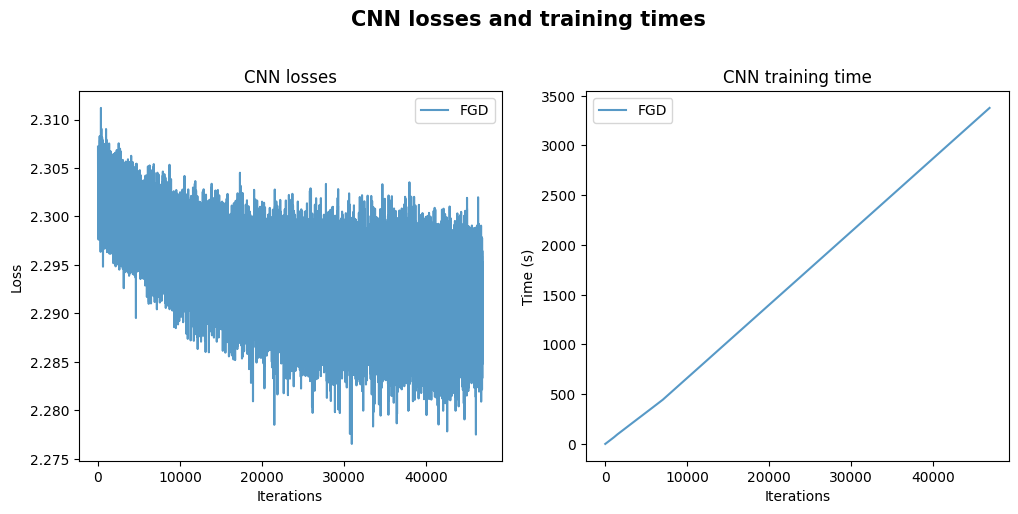

In [38]:
# Train CNN with FGD
cnn_fgd_l, cnn_fgd_t = train_fgd(CNN(), train_loader=train_loader, num_epochs=50)
# Train CNN with SGD
# cnn_sgd_l, cnn_sgd_t = train_sgd(CNN(), train_loader=train_loader, num_epochs=50)

# Set up a figure
fig = plt.figure(figsize=plt.figaspect(.4))
fig.suptitle("CNN losses and training times", fontsize=15, fontweight='bold', y=1.05)

# First subplot (Losses)
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("CNN losses")
ax1.plot(cnn_fgd_l, label='FGD', alpha=0.75)
# ax1.plot(cnn_sgd_l, label='SGD', alpha=0.75)
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Loss")
ax1.legend()

# Second subplot (Times)
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("CNN training time")
ax2.plot(cnn_fgd_t, label='FGD', alpha=0.75)
# ax2.plot(cnn_sgd_t, label='SGD', alpha=0.75)
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Time (s)")
ax2.legend()

plt.show()

In [40]:
# Given a model, train it using SGD
def train_sgd(model, train_loader, num_epochs=20, learning_rate=2e-4, input_size=28*28):
    print(f'\n\nTraining {model.__class__.__name__} with SGD for {num_epochs} epochs...')

    # Define criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # Initialize losses and times
    losses = list()
    times = list([0])

    # Train the model
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            # Start time
            t0 = time.time()
            # Reshape the images (for FNN only)
            if isinstance(model, FNN): images = images.reshape(-1, input_size)
            # Zero the gradients
            optimizer.zero_grad()
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            # Backward and optimize
            loss.backward()
            optimizer.step()
            # End time
            t1 = time.time()
            # Update losses and times
            losses.append(loss.item())
            times.append(times[-1]+t1-t0)  
            # Print the statistics
            if (i+1) % batch_size == 0:
                print (f'Epoch [{epoch+1}/{num_epochs}],\tStep [{i+1}/{len(train_loader)}],\t' +
                        f'Iteraion [{i+1+epoch*len(train_loader)}/{len(train_loader)*num_epochs}],\t' +
                        f'Loss: {loss:.4f},\tTime: {t1-t0:.2f}')
    print('Finished SGD Training')
    return losses, times



Training CNN with SGD for 50 epochs...
Epoch [1/50],	Step [64/938],	Iteraion [64/46900],	Loss: 2.3034,	Time: 0.05
Epoch [1/50],	Step [128/938],	Iteraion [128/46900],	Loss: 2.3036,	Time: 0.04
Epoch [1/50],	Step [192/938],	Iteraion [192/46900],	Loss: 2.3002,	Time: 0.03
Epoch [1/50],	Step [256/938],	Iteraion [256/46900],	Loss: 2.3018,	Time: 0.04
Epoch [1/50],	Step [320/938],	Iteraion [320/46900],	Loss: 2.3006,	Time: 0.05
Epoch [1/50],	Step [384/938],	Iteraion [384/46900],	Loss: 2.3039,	Time: 0.03
Epoch [1/50],	Step [448/938],	Iteraion [448/46900],	Loss: 2.3012,	Time: 0.05
Epoch [1/50],	Step [512/938],	Iteraion [512/46900],	Loss: 2.3010,	Time: 0.06
Epoch [1/50],	Step [576/938],	Iteraion [576/46900],	Loss: 2.3004,	Time: 0.04
Epoch [1/50],	Step [640/938],	Iteraion [640/46900],	Loss: 2.3031,	Time: 0.03
Epoch [1/50],	Step [704/938],	Iteraion [704/46900],	Loss: 2.3011,	Time: 0.05
Epoch [1/50],	Step [768/938],	Iteraion [768/46900],	Loss: 2.3011,	Time: 0.05
Epoch [1/50],	Step [832/938],	Iteraio

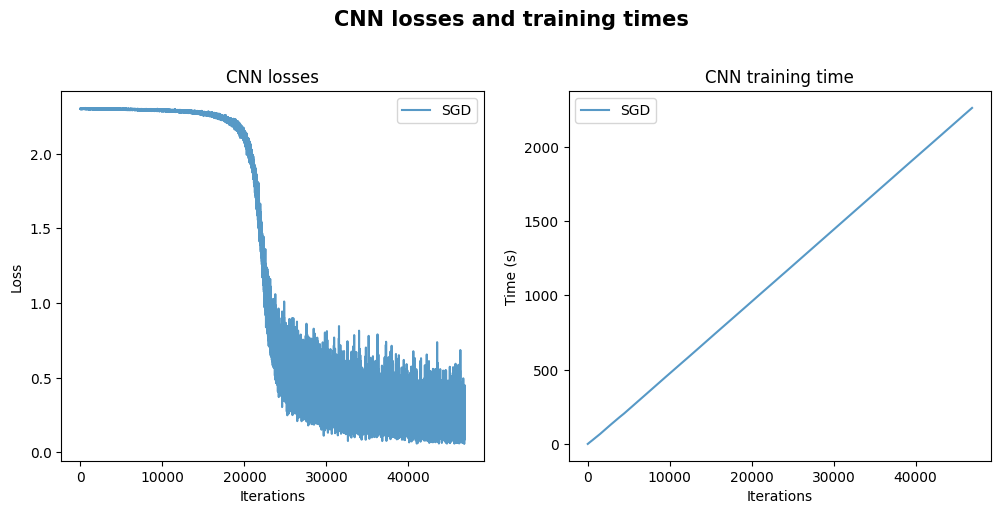

In [41]:
# Train CNN with FGD
# cnn_fgd_l, cnn_fgd_t = train_fgd(CNN(), train_loader=train_loader, num_epochs=50)
# Train CNN with SGD
cnn_sgd_l, cnn_sgd_t = train_sgd(CNN(), train_loader=train_loader, num_epochs=50)

# Set up a figure
fig = plt.figure(figsize=plt.figaspect(.4))
fig.suptitle("CNN losses and training times", fontsize=15, fontweight='bold', y=1.05)

# First subplot (Losses)
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("CNN losses")
# ax1.plot(cnn_fgd_l, label='FGD', alpha=0.75)
ax1.plot(cnn_sgd_l, label='SGD', alpha=0.75)
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Loss")
ax1.legend()

# Second subplot (Times)
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("CNN training time")
# ax2.plot(cnn_fgd_t, label='FGD', alpha=0.75)
ax2.plot(cnn_sgd_t, label='SGD', alpha=0.75)
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Time (s)")
ax2.legend()

plt.show()